# Setup

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/[2024-2025] AN2DL HW2

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1z5t8kqLSNnsGWmeDMitEc48VDF9xBUOx/[2024-2025] AN2DL HW2


In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## Split

In [ ]:
# Load the cleaned dataset
data = np.load("mars_cleaned_dataset.npz")
X = data["X_train"]
y = data["y_train"]

# Split
test_size = 0.15
adjusted_val_size = 0.176
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=test_size, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=adjusted_val_size, random_state=seed
)

# Turning np dataset in tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch the datasets
BATCH_SIZE = 8
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=False)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)

# Optionally, you can shuffle and prefetch for performance optimization
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

# Print out the number of batches in each dataset (after batching)
print(f"\nNumber of batches:")
print(f"Train: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")


Number of batches:
Train: 220
Validation: 47
Test: 47


## Class Weights

In [ ]:
# Define class labels for better readability
class_labels = ["Background", "Soil", "Bedrock", "Sand", "Big Rock"]

# Ensure input is a 1D array of integers
y_vector = np.ravel(y_train).astype(int)

# Calculate class counts
class_counts = np.bincount(y_vector, minlength=len(class_labels))

# Calculate frequency percentages
class_frequencies = class_counts / np.sum(class_counts) * 100

# Display class counts and percentages
print("Class Distribution:\n")
for i, (count, freq) in enumerate(zip(class_counts, class_frequencies)):
    print(f"Class {i} ({class_labels[i]}):")
    print(f"    Pixels: {count}")
    print(f"    Frequency: {freq:.2f}%")

# Calculate raw weights as the inverse of the frequencies
raw_weights = {cls: 1.0 / freq for cls, freq in zip(range(len(class_frequencies)), class_frequencies)}

# Normalize the weights so that their sum equals the number of classes
sum_of_raw_weights = sum(raw_weights.values())
num_classes = len(class_labels)

normalized_weights = {cls: (weight / sum_of_raw_weights) * num_classes for cls, weight in raw_weights.items()}

# Display results
print("Class Frequencies:", class_frequencies)
print("Raw Weights:", raw_weights)
print("Normalized Weights:", normalized_weights)

Class Distribution:

Class 0 (Background):
    Pixels: 3512496
    Frequency: 24.45%
Class 1 (Soil):
    Pixels: 4863886
    Frequency: 33.85%
Class 2 (Bedrock):
    Pixels: 3498998
    Frequency: 24.35%
Class 3 (Sand):
    Pixels: 2473313
    Frequency: 17.21%
Class 4 (Big Rock):
    Pixels: 20075
    Frequency: 0.14%
Class Frequencies: [24.44535259 33.85040388 24.35141273 17.21311806  0.13971274]
Raw Weights: {0: 0.04090757114029454, 1: 0.029541745016227763, 2: 0.0410653792885849, 3: 0.05809522692841545, 4: 7.157543212951432}
Normalized Weights: {0: 0.027915051306267202, 1: 0.02015908803229728, 2: 0.02802273852487435, 3: 0.0396437919717635, 4: 4.884259330164797}


## Base Architecture

In [ ]:
# Define custom Mean Intersection Over Union metric
@tf.keras.utils.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

The original U-Net paper demonstrates the effectiveness of skip connections in preserving spatial information lost during downsampling. This makes U-Net more sensitive to fine-grained details, which is crucial when comparing the effects of different preprocessing techniques (e.g., augmentations or noise injections). Without skip connections, the model might not fully exploit the improved spatial details provided by preprocessing, making it harder to evaluate the true impact of these techniques.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Parameters
INPUT_SHAPE = (64, 128, 1)
NUM_CLASSES = 5
LEARNING_RATE = 1e-4
EPOCHS = 500
PATIENCE = 5

# Callbacks
lr_reduction = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=PATIENCE,
    min_lr=1e-6,
    factor=0.2,
    verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=EPOCHS,
    restore_best_weights=True
)
callbacks = [lr_reduction, early_stopping]

In [ ]:
import json
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint

# Define U-Net block
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

# Define U-Net model
def unet(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

def train(loss_fn, train_dataset, val_dataset):
    global LEARNING_RATE, EPOCHS, NUM_CLASSES, lr_reduction, unet  # Use global variables

    # Create the model
    model = unet()

    # Compile the model
    model.compile(
        loss=loss_fn,
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
        metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
    )

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=1
    ).history

    # Calculate the final validation MeanIoU
    final_val_meanIoU = round(max(history.get('val_mean_iou', [0])) * 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

    # Create a timestamp for unique file naming
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # Save the model with the accuracy in the filename
    model_filename = f'UNet_{loss_fn.__class__.__name__}_{final_val_meanIoU}_{timestamp}.keras'
    model.save(model_filename)
    print(f'Model saved as {model_filename}')

    # Save training history as a JSON file
    history_filename = f"history_{loss_fn}_{timestamp}.json"
    with open(history_filename, 'w') as f:
        json.dump(history, f)
    print(f"Training history saved as {history_filename}")

    # Delete the model to free up resources
    del model

    # Return the history dictionary
    return history

In [ ]:
def plot_history(history, loss_fn):
    """
    Plots training and validation loss, accuracy, and mean IoU from the training history.

    Parameters:
    history (dict): The training history containing 'loss', 'val_loss', 'accuracy', 'val_accuracy',
                    'mean_iou', and 'val_mean_iou'.
    loss_fn (str): The loss function used in the training (e.g., 'SparseCategoricalCrossentropy').
    """
    metrics = {
        "Loss (" + loss_fn.__class__.__name__ + ")": ("loss", "val_loss"),
        "Accuracy": ("accuracy", "val_accuracy"),
        "Mean Intersection Over Union": ("mean_iou", "val_mean_iou")
    }

    # Plot the metrics
    for title, (train_key, val_key) in metrics.items():
        plt.figure(figsize=(18, 3))
        plt.plot(history[train_key], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
        plt.plot(history[val_key], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
        plt.title(title)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

In [ ]:
from matplotlib.colors import ListedColormap

# Define class labels and colormap
CLASS_LABELS = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}
COLORS = ["black", "brown", "gray", "yellow", "darkred"]
cmap = ListedColormap(COLORS)

def plot_triptychs(dataset, model, num_samples=1, seed=42):
    """
    Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset

    Parameters:
    dataset: tf.data.Dataset - The dataset containing image-label pairs
    model: tf.keras.Model - The trained model to generate predictions
    num_samples: int - Number of samples to plot
    seed: int - Random seed for shuffling the dataset
    """
    # Shuffle the dataset and then take `num_samples` random samples
    shuffled_dataset = dataset.shuffle(buffer_size=1000, seed=seed)
    samples = shuffled_dataset.take(num_samples)

    for images, labels in samples:
        # If we have a batch, take the first example
        if len(images.shape) == 4:  # Batch of images
            images = images[0:1]
            labels = labels[0:1]

        # Generate predictions
        pred = model.predict(images, verbose=0)
        pred = tf.math.argmax(pred, axis=-1)

        # Create figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(20, 4))

        # Plot original image
        axes[0].set_title("Original Image")
        axes[0].imshow(images[0], cmap='gray')  # Assuming grayscale images
        axes[0].axis('off')

        # Plot original mask
        axes[1].set_title("Original Mask")
        axes[1].imshow(labels[0], cmap=cmap, vmin=0, vmax=len(CLASS_LABELS)-1)
        axes[1].axis('off')

        # Plot predicted mask
        axes[2].set_title("Predicted Mask")
        im = axes[2].imshow(pred[0], cmap=cmap, vmin=0, vmax=len(CLASS_LABELS)-1)
        axes[2].axis('off')

        # Add a color legend for the segmentation classes
        cbar = plt.colorbar(im, ax=axes[2], fraction=0.022, pad=0.04)
        cbar.set_ticks(range(len(CLASS_LABELS)))
        cbar.set_ticklabels([CLASS_LABELS[i] for i in range(len(CLASS_LABELS))])

        plt.tight_layout()
        plt.show()
        plt.close()

In [ ]:
def contains_big_rock(images, label):
    """
    Check if the label contains the undersampled class 'Big Rock' (class label 4).

    Parameters:
    label: tf.Tensor - The label tensor

    Returns:
    bool - True if the label contains 'Big Rock', otherwise False
    """
    return tf.reduce_any(label == 4)

# Filter the test dataset to include only samples containing 'Big Rock'
filtered_test_dataset = test_dataset.unbatch().filter(lambda image, label: contains_big_rock(image, label)).batch(64)

# Baseline (no class balancing techniques)

Epoch 1/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - accuracy: 0.3397 - loss: 1.6057 - mean_iou: 0.1561 - val_accuracy: 0.5031 - val_loss: 1.3358 - val_mean_iou: 0.2759 - learning_rate: 1.0000e-04
Epoch 2/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5415 - loss: 1.2302 - mean_iou: 0.2767 - val_accuracy: 0.5831 - val_loss: 1.1239 - val_mean_iou: 0.3163 - learning_rate: 1.0000e-04
Epoch 3/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5978 - loss: 1.1018 - mean_iou: 0.3209 - val_accuracy: 0.6257 - val_loss: 1.0333 - val_mean_iou: 0.3411 - learning_rate: 1.0000e-04
Epoch 4/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5944 - loss: 1.0607 - mean_iou: 0.3209 - val_accuracy: 0.6546 - val_loss: 0.9446 - val_mean_iou: 0.3501 - learning_rate: 1.0000e-04
Epoch 5/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6077 - loss: 1.0315 - mean_iou: 0.3299 - val_accuracy: 0.6414 - val_loss: 0.9481 - val_mean_iou: 0.3349 - learning_rate: 1.0000e-04

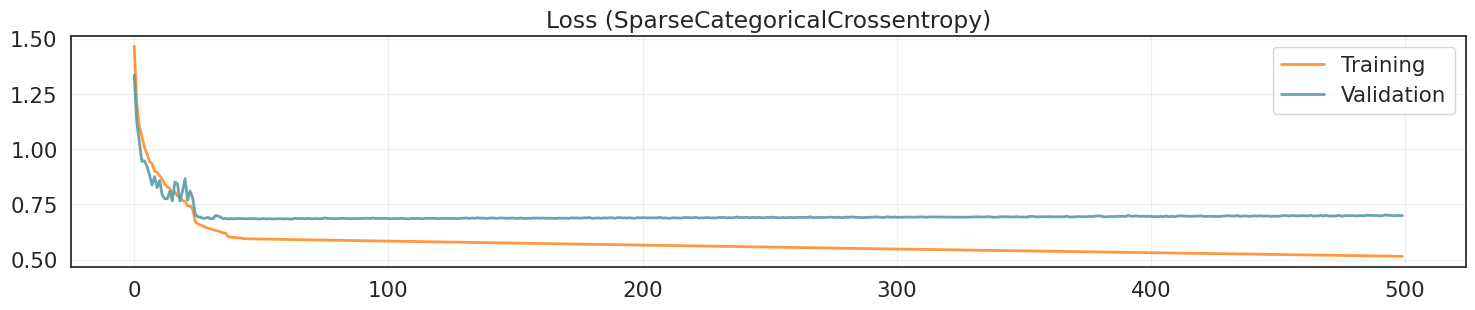

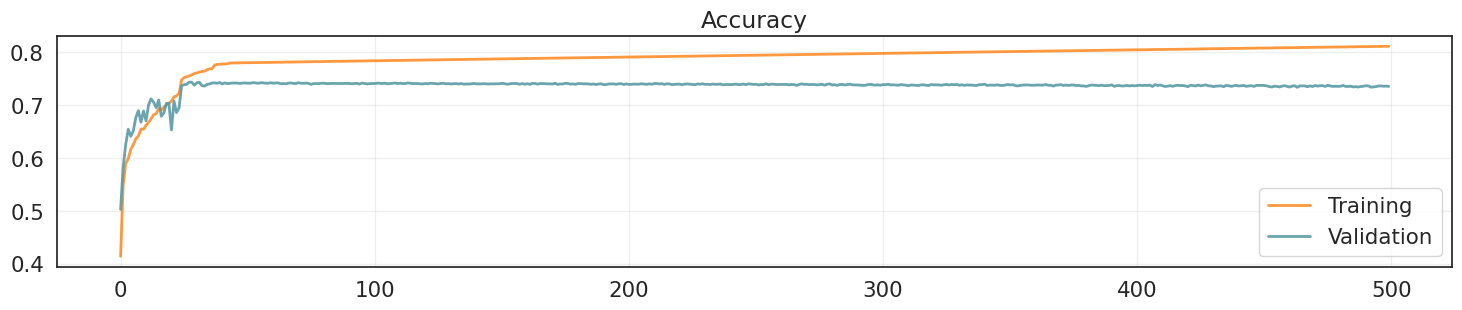

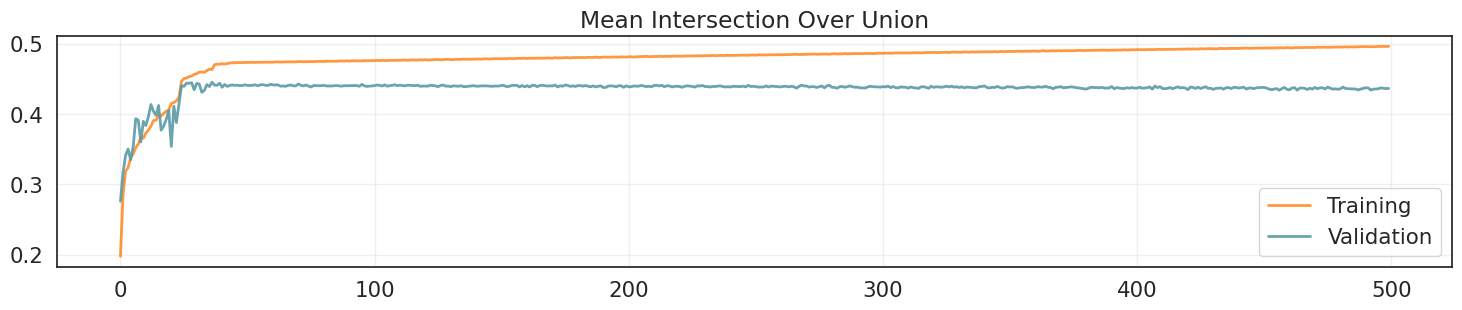

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
plot_history(train(loss_fn=loss, train_dataset=train_dataset, val_dataset=val_dataset), loss)

Test Accuracy: 0.7228
Test Mean Intersection over Union: 0.4239


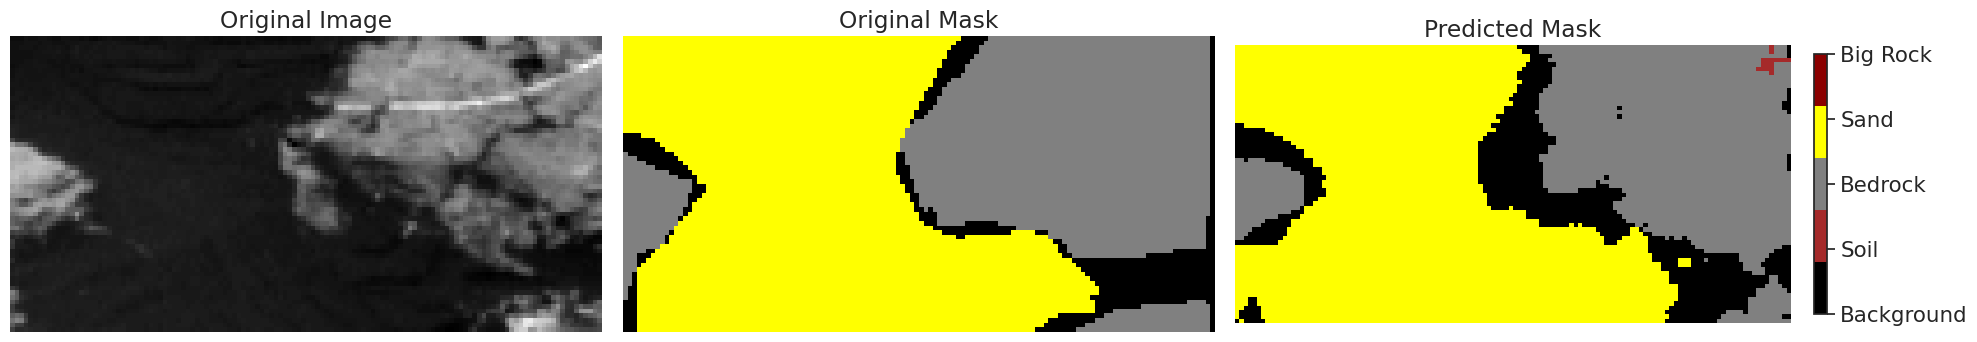

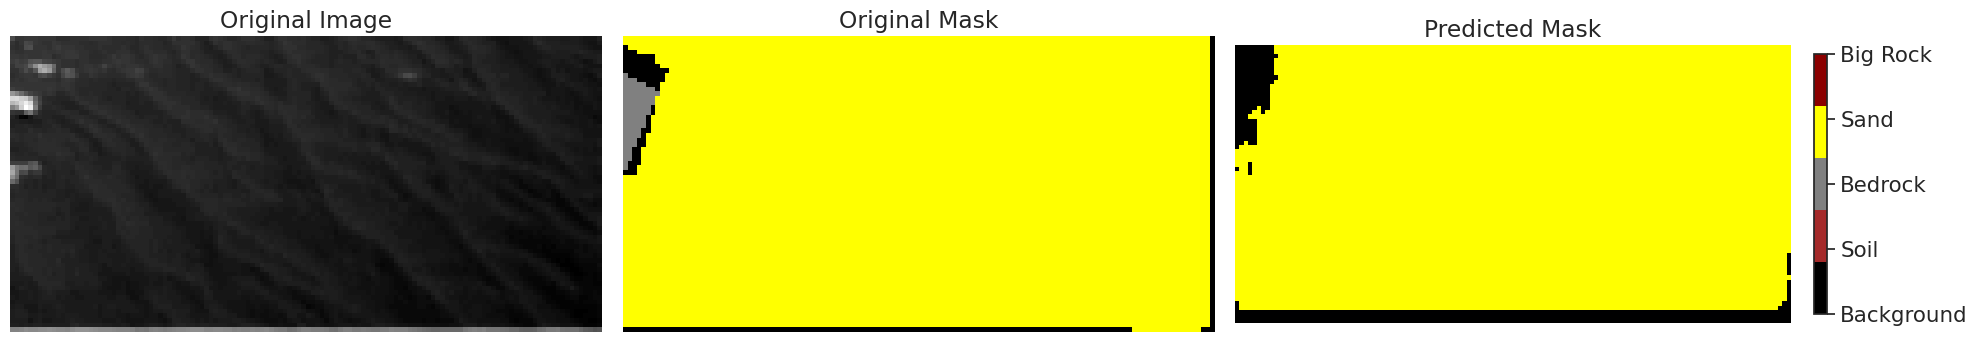

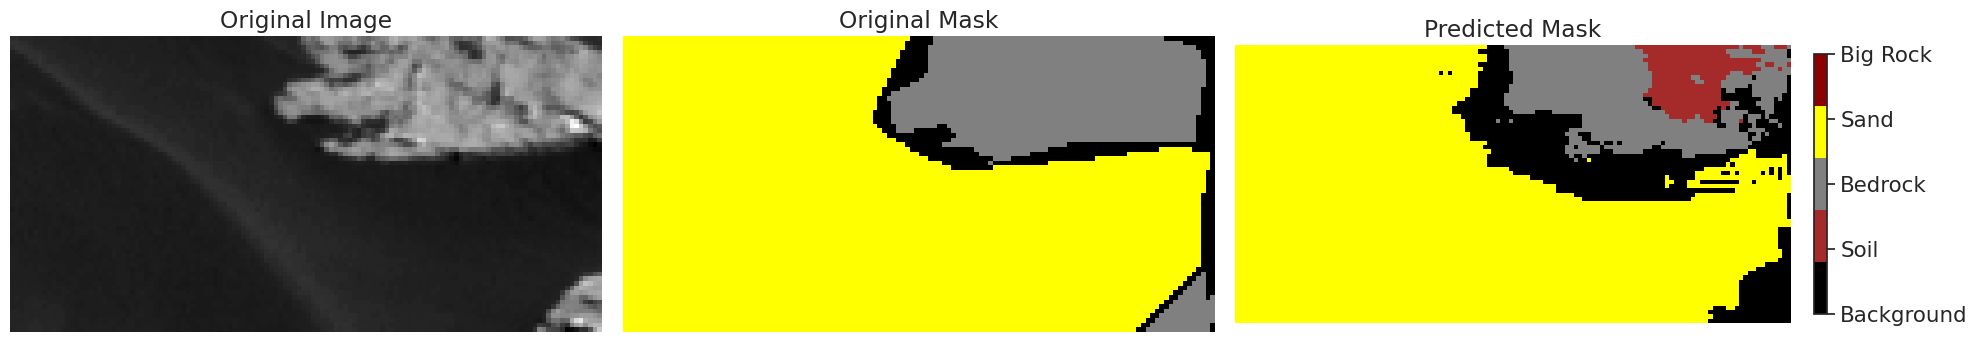

In [ ]:
# Load model
model = tfk.models.load_model(os.path.join('loss_functions', 'UNet_SparseCategoricalCrossentropy_44.54_20241201-213944.keras'), compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

# Plot three random samples
plot_triptychs(test_dataset, model, num_samples=3)

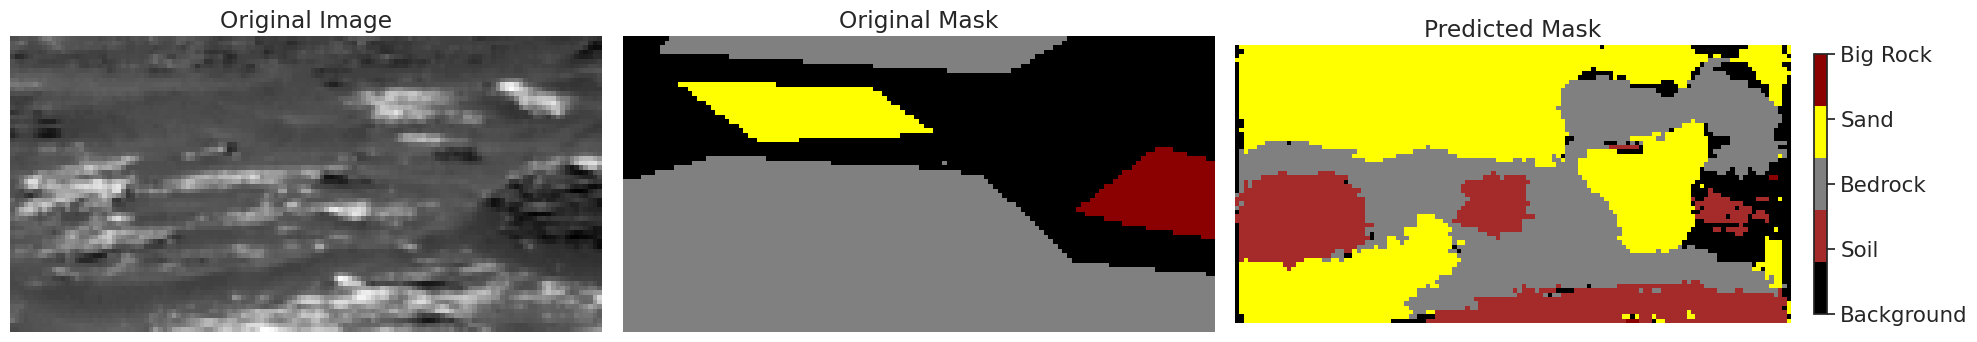

In [ ]:
# Plot triptychs using the filtered dataset
plot_triptychs(filtered_test_dataset, model, num_samples=5, seed=42)

# Different Loss Functions

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def weighted_cross_entropy_loss(weights):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)  # Avoid log(0)
        y_true_one_hot = tf.one_hot(y_true, depth=len(weights))
        weights_tensor = tf.constant(list(weights.values()), dtype=tf.float32)  # Use list to extract values from dictionary
        weighted_cross_entropy = tf.reduce_sum(weights_tensor * y_true_one_hot * tf.math.log(y_pred), axis=-1)
        return -tf.reduce_mean(weighted_cross_entropy)
    return loss

def focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * tf.pow(1 - y_pred, gamma)
        focal_loss = tf.reduce_sum(weights * cross_entropy, axis=-1)
        return tf.reduce_mean(focal_loss)
    return loss_fn

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)  # Ensure numerical stability
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)

def combined_loss(weights, alpha=0.5, beta=0.5):
    def loss(y_true, y_pred):
        wce_loss = weighted_cross_entropy_loss(weights)(y_true, y_pred)
        dice = dice_loss(y_true, y_pred)
        return alpha * dice + beta * wce_loss
    return loss

## Weighted Cross-Entropy Loss

Epoch 1/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.2477 - loss: 0.0538 - mean_iou: 0.1204 - val_accuracy: 0.3658 - val_loss: 0.0432 - val_mean_iou: 0.1892 - learning_rate: 1.0000e-04
Epoch 2/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3506 - loss: 0.0463 - mean_iou: 0.1916 - val_accuracy: 0.4480 - val_loss: 0.0400 - val_mean_iou: 0.2439 - learning_rate: 1.0000e-04
Epoch 3/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4324 - loss: 0.0424 - mean_iou: 0.2401 - val_accuracy: 0.4831 - val_loss: 0.0410 - val_mean_iou: 0.2829 - learning_rate: 1.0000e-04
Epoch 4/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4652 - loss: 0.0402 - mean_iou: 0.2666 - val_accuracy: 0.4086 - val_loss: 0.0400 - val_mean_iou: 0.2361 - learning_rate: 1.0000e-04
Epoch 5/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4591 - loss: 0.0409 - mean_iou: 0.2661 - val_accuracy: 0.5400 - val_loss: 0.0343 - val_mean_iou: 0.3164 - learning_rate: 1.0000e-04

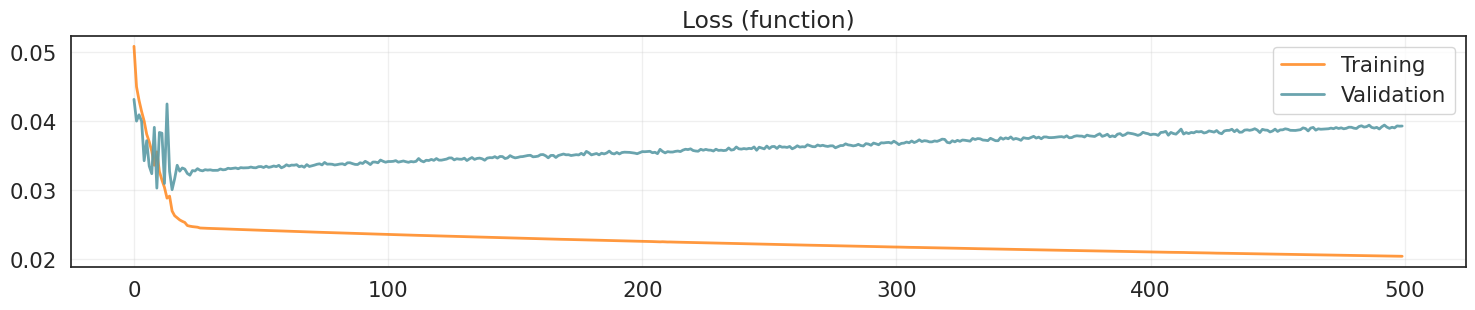

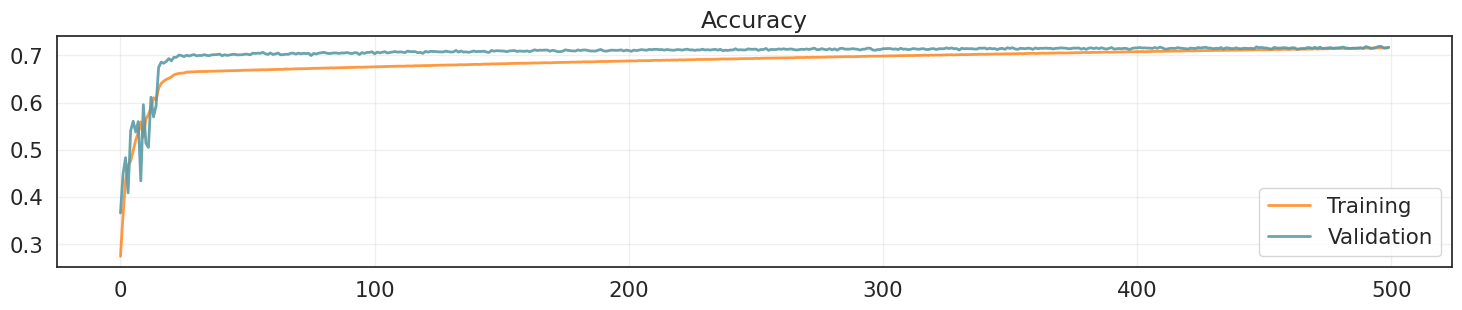

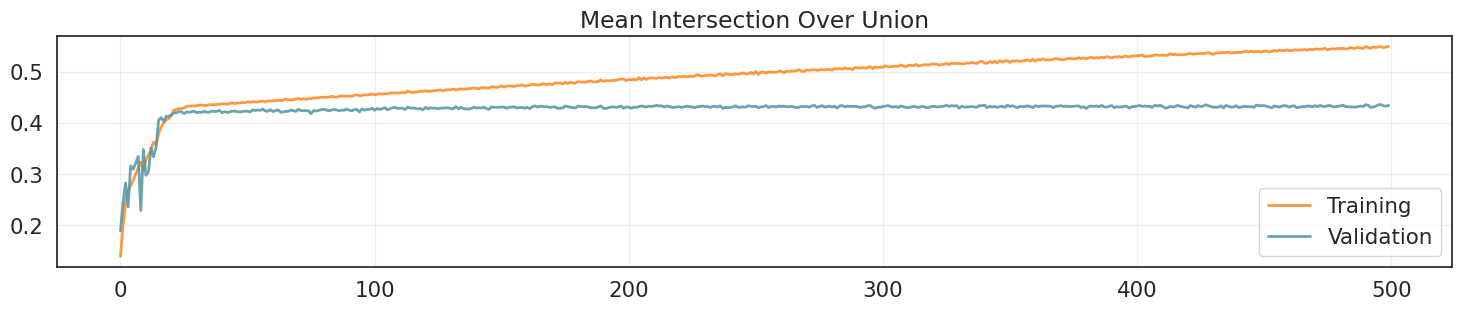

In [ ]:
loss = weighted_cross_entropy_loss(normalized_weights)
plot_history(train(loss_fn=loss, train_dataset=train_dataset, val_dataset=val_dataset), loss)

Test Accuracy: 0.6589
Test Mean Intersection over Union: 0.392


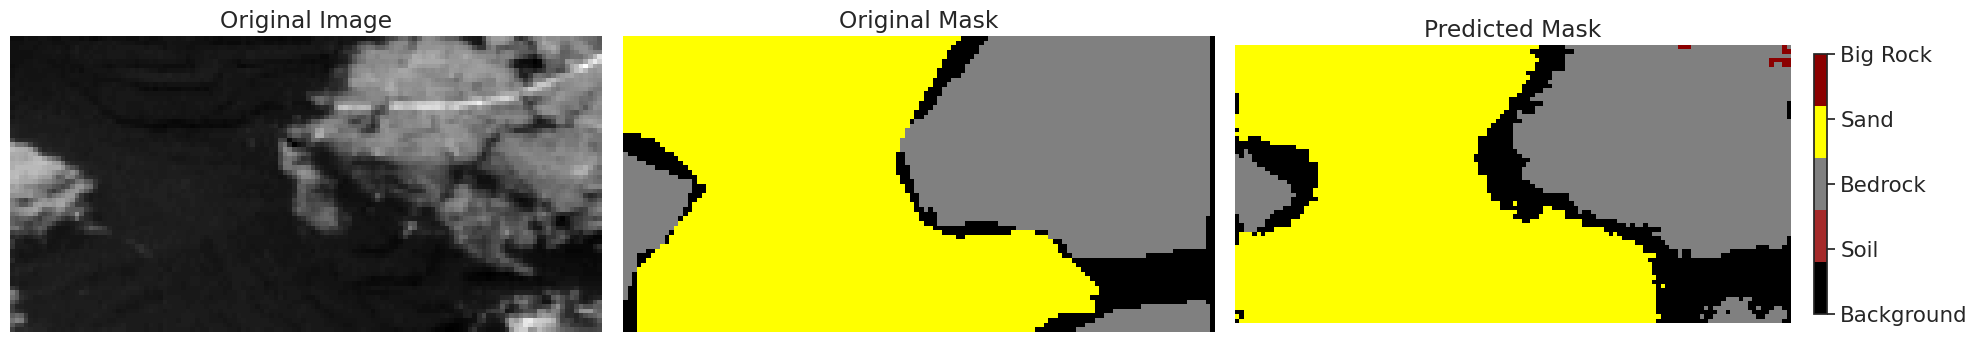

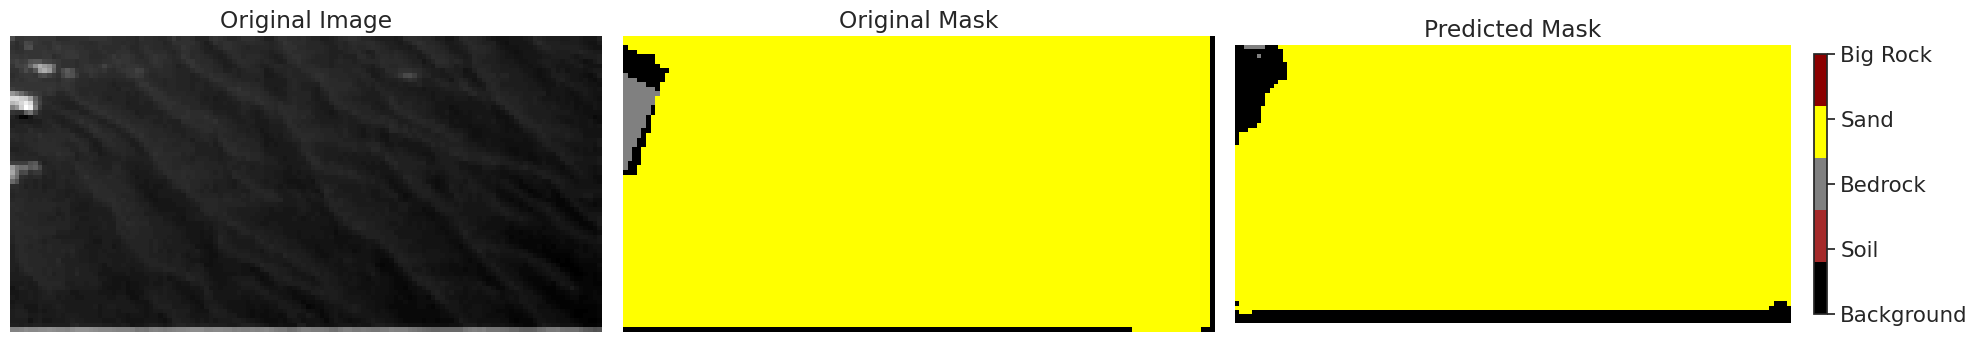

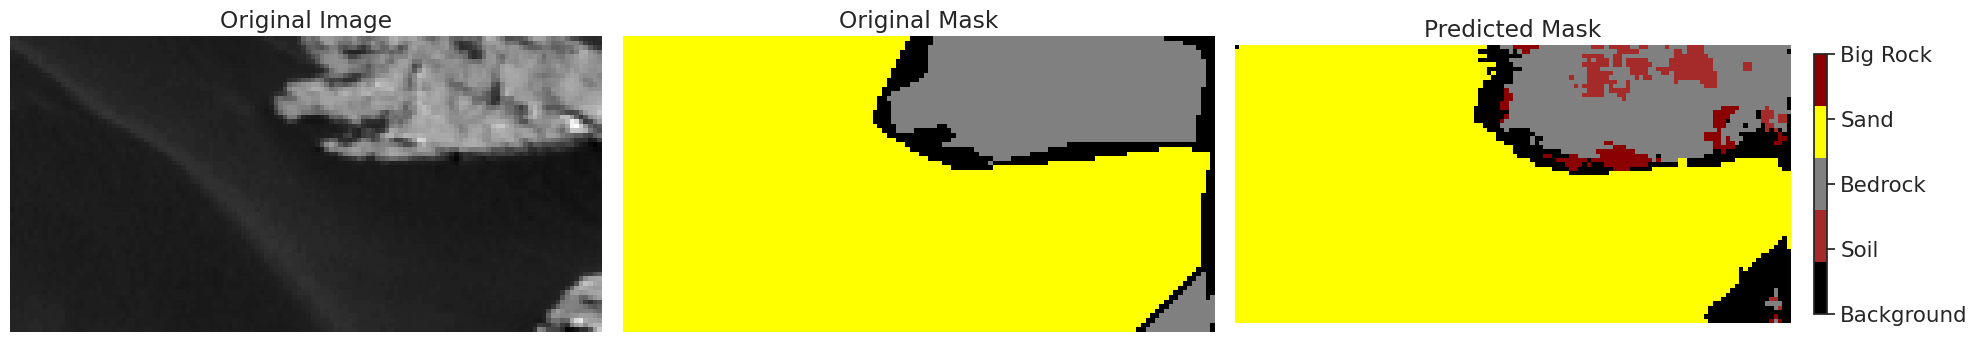

In [ ]:
# Load model
model = tfk.models.load_model(os.path.join('loss_functions', 'UNet_function_43.57_20241201-214010.keras'), compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=weighted_cross_entropy_loss(normalized_weights),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

# Plot three random samples
plot_triptychs(test_dataset, model, num_samples=3)

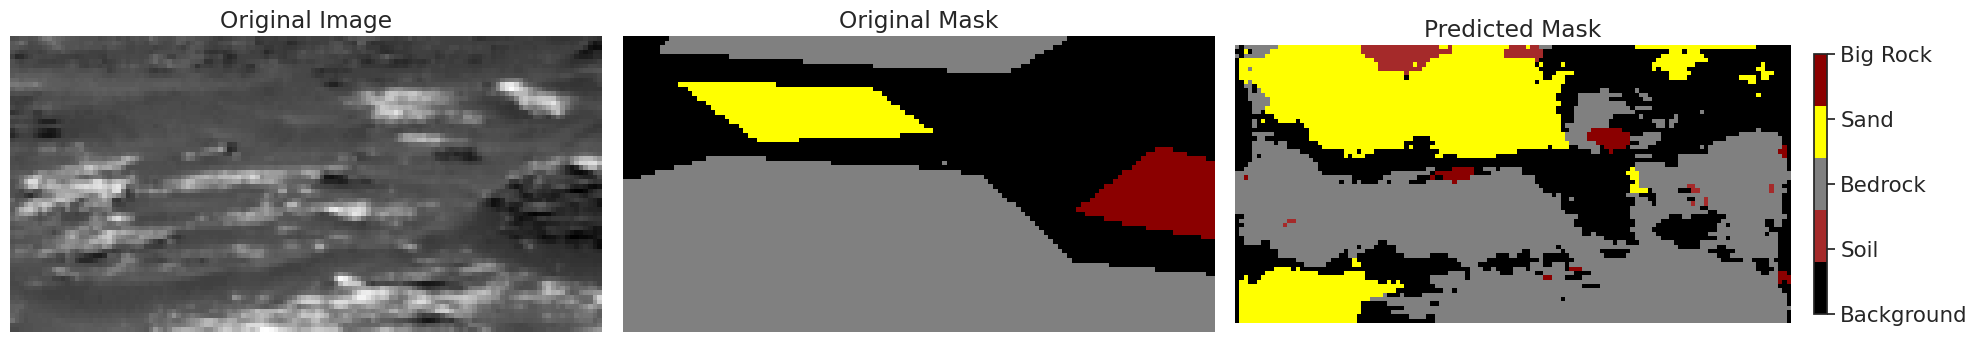

In [ ]:
# Plot triptychs using the filtered dataset
plot_triptychs(filtered_test_dataset, model, num_samples=5, seed=42)

## Focal Loss

Epoch 1/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.3300 - loss: 0.2703 - mean_iou: 0.1498 - val_accuracy: 0.4874 - val_loss: 0.2050 - val_mean_iou: 0.2610 - learning_rate: 1.0000e-04
Epoch 2/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.5249 - loss: 0.1797 - mean_iou: 0.2648 - val_accuracy: 0.5727 - val_loss: 0.1620 - val_mean_iou: 0.3101 - learning_rate: 1.0000e-04
Epoch 3/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5840 - loss: 0.1535 - mean_iou: 0.3100 - val_accuracy: 0.6113 - val_loss: 0.1449 - val_mean_iou: 0.3317 - learning_rate: 1.0000e-04
Epoch 4/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5864 - loss: 0.1431 - mean_iou: 0.3166 - val_accuracy: 0.6425 - val_loss: 0.1257 - val_mean_iou: 0.3489 - learning_rate: 1.0000e-04
Epoch 5/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5916 - loss: 0.1389 - mean_iou: 0.3164 - val_accuracy: 0.6424 - val_loss: 0.1218 - val_mean_iou: 0.3502 - learning_rate: 1.0000e-0

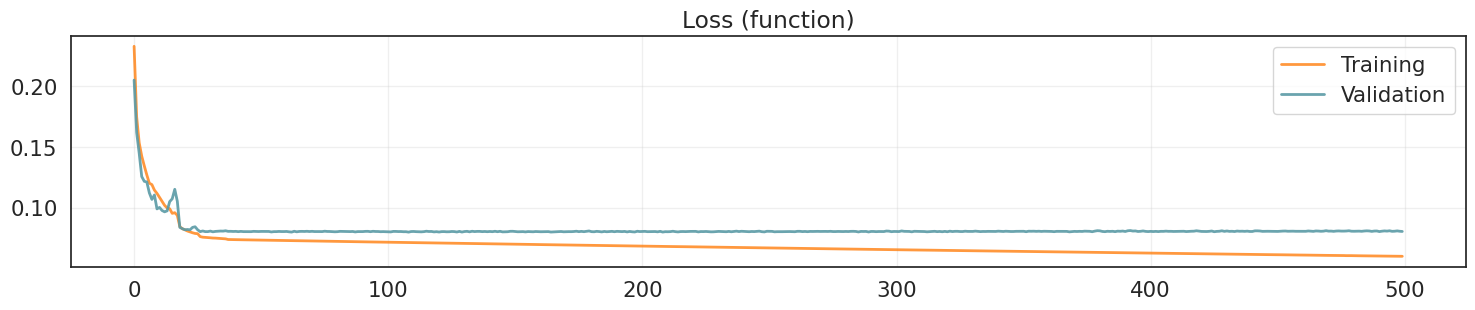

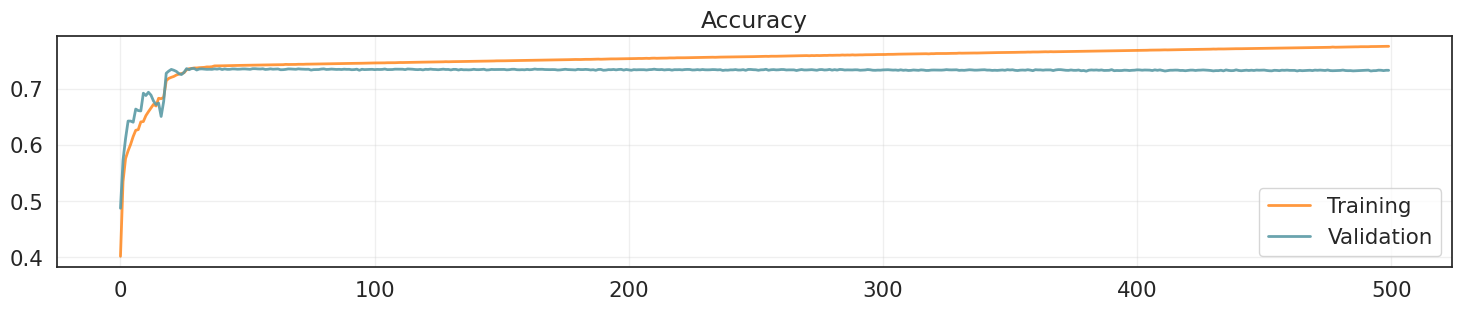

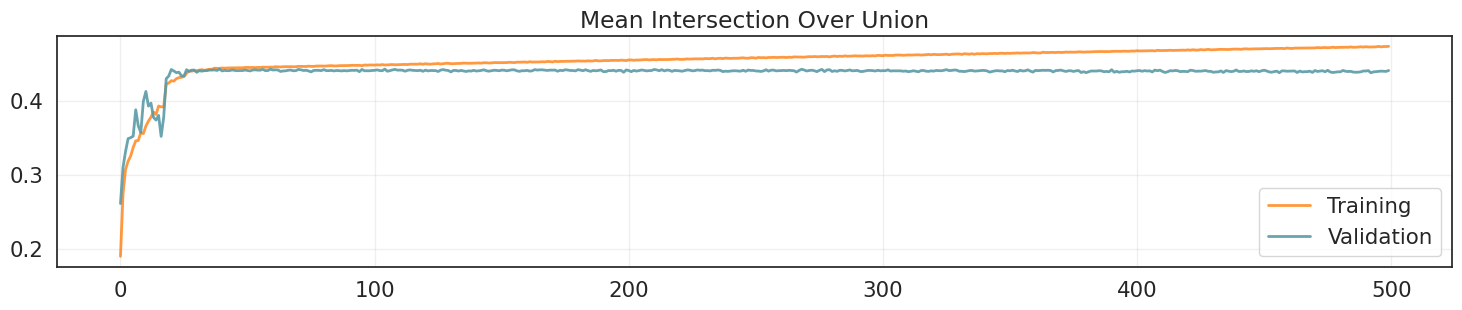

In [ ]:
loss = focal_loss()
plot_history(train(loss_fn=loss, train_dataset=train_dataset, val_dataset=val_dataset), loss)

Test Accuracy: 0.7156
Test Mean Intersection over Union: 0.4235


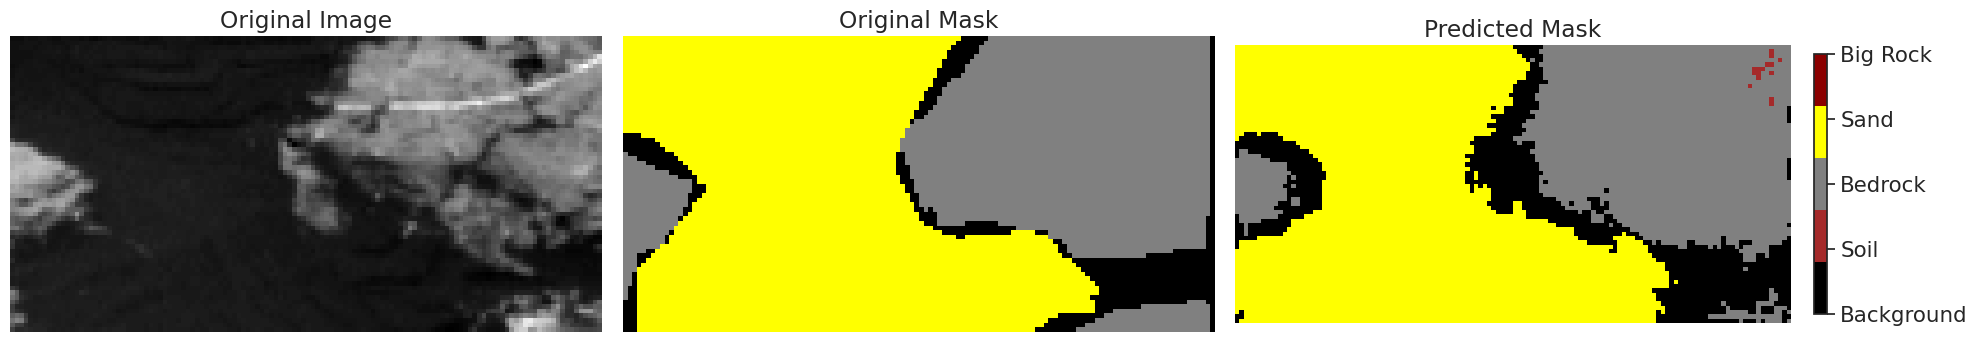

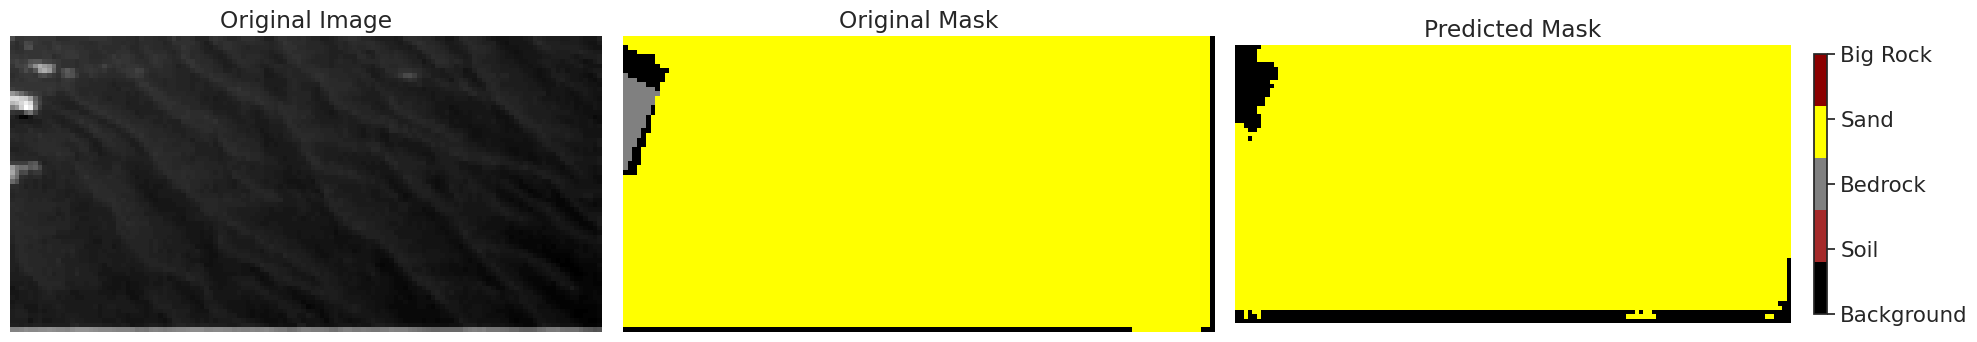

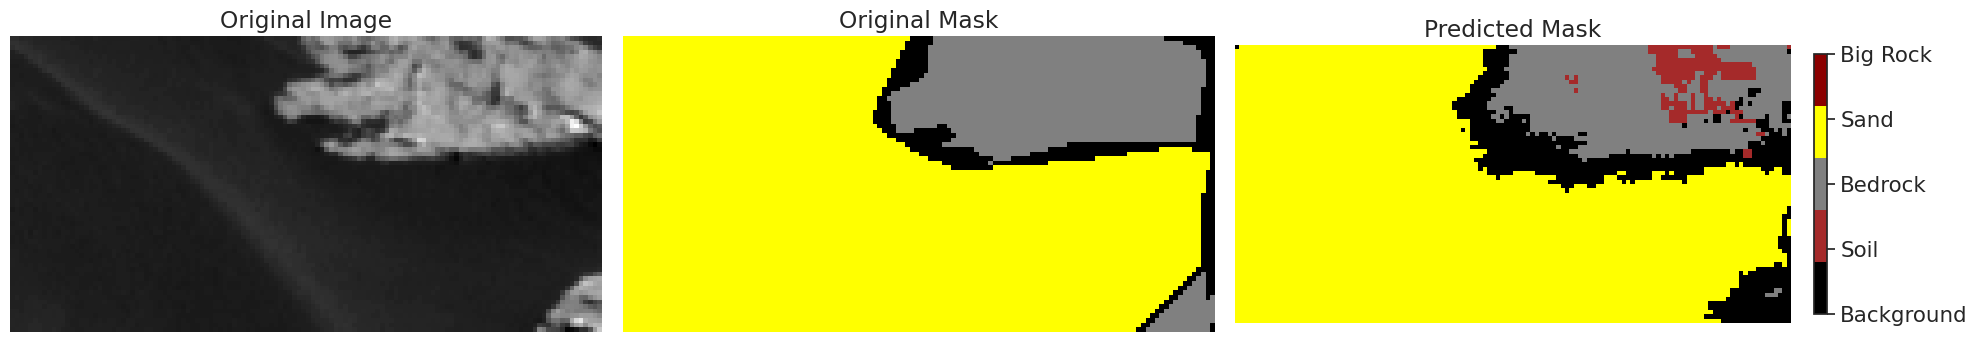

In [ ]:
# Load model
model = tfk.models.load_model(os.path.join('loss_functions', 'UNet_function_44.31_20241201-214145.keras'), compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=focal_loss(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

# Plot three random samples
plot_triptychs(test_dataset, model, num_samples=3)

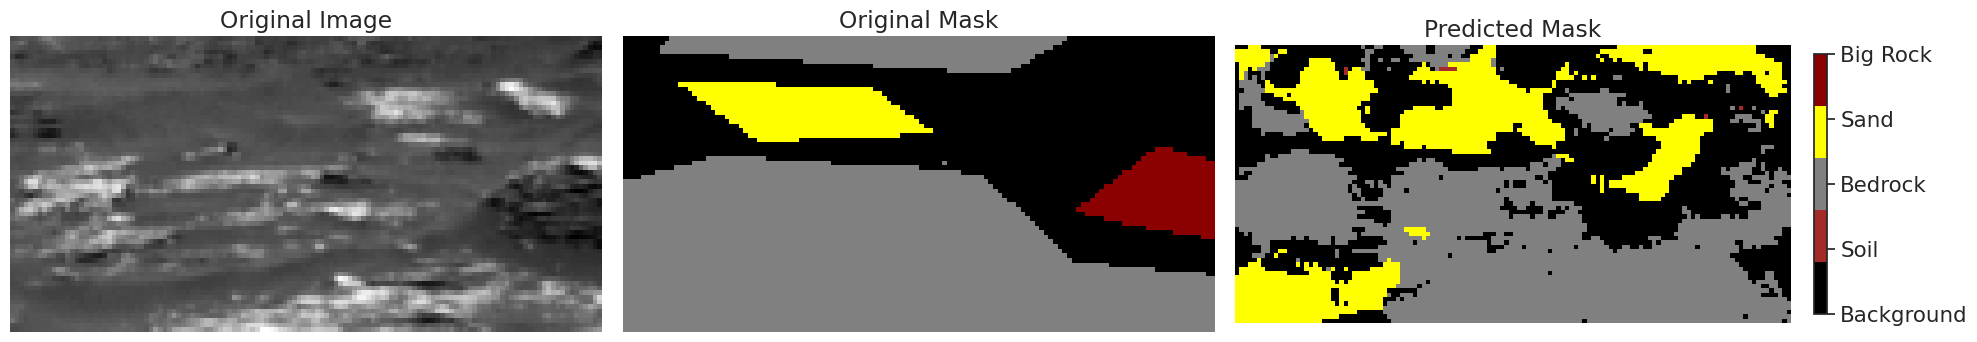

In [ ]:
# Plot triptychs using the filtered dataset
plot_triptychs(filtered_test_dataset, model, num_samples=5, seed=42)

## Dice Loss

Epoch 1/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 29s 70ms/step - accuracy: 0.3947 - loss: 0.6699 - mean_iou: 0.1513 - val_accuracy: 0.5257 - val_loss: 0.5349 - val_mean_iou: 0.2399 - learning_rate: 1.0000e-04
Epoch 2/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5272 - loss: 0.5197 - mean_iou: 0.2603 - val_accuracy: 0.6189 - val_loss: 0.4144 - val_mean_iou: 0.3352 - learning_rate: 1.0000e-04
Epoch 3/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5699 - loss: 0.4611 - mean_iou: 0.2965 - val_accuracy: 0.6267 - val_loss: 0.3982 - val_mean_iou: 0.3209 - learning_rate: 1.0000e-04
Epoch 4/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5924 - loss: 0.4314 - mean_iou: 0.3092 - val_accuracy: 0.5497 - val_loss: 0.4658 - val_mean_iou: 0.2980 - learning_rate: 1.0000e-04
Epoch 5/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5994 - loss: 0.4207 - mean_iou: 0.3183 - val_accuracy: 0.6372 - val_loss: 0.3783 - val_mean_iou: 0.3454 - learning_rate: 1.0000e-04

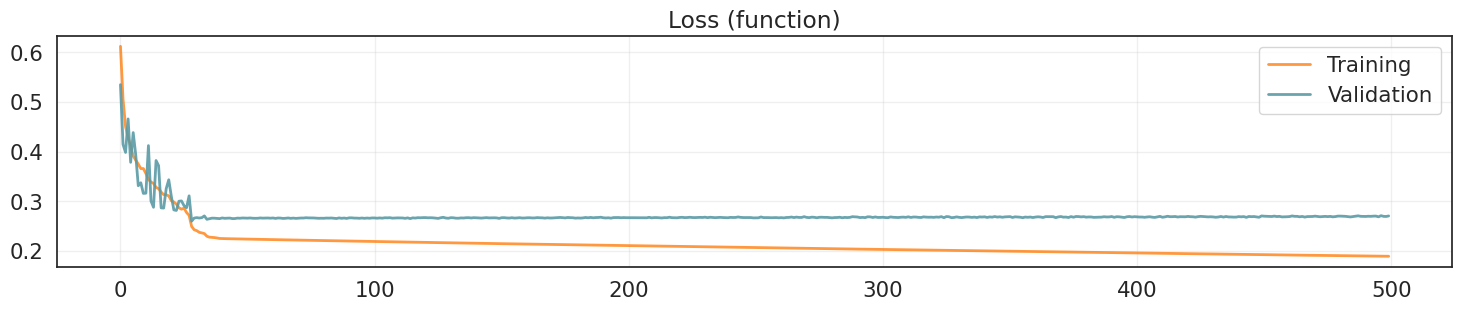

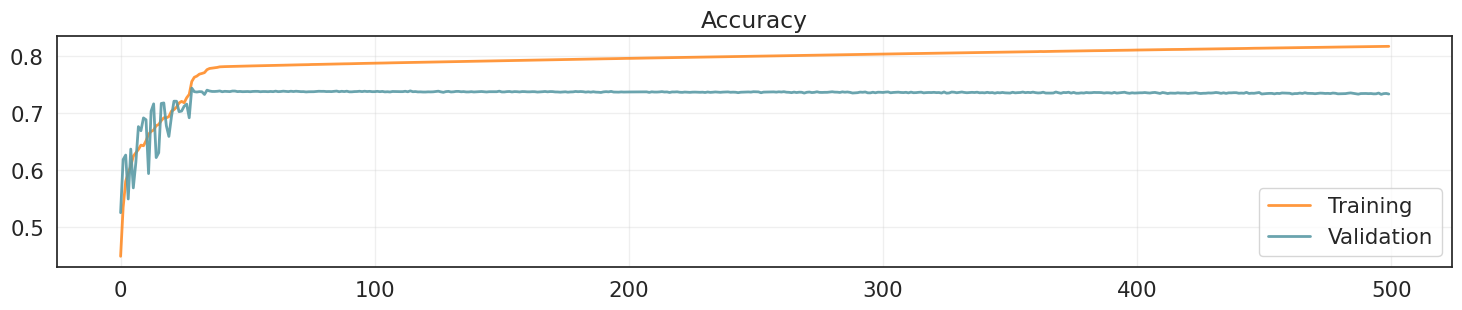

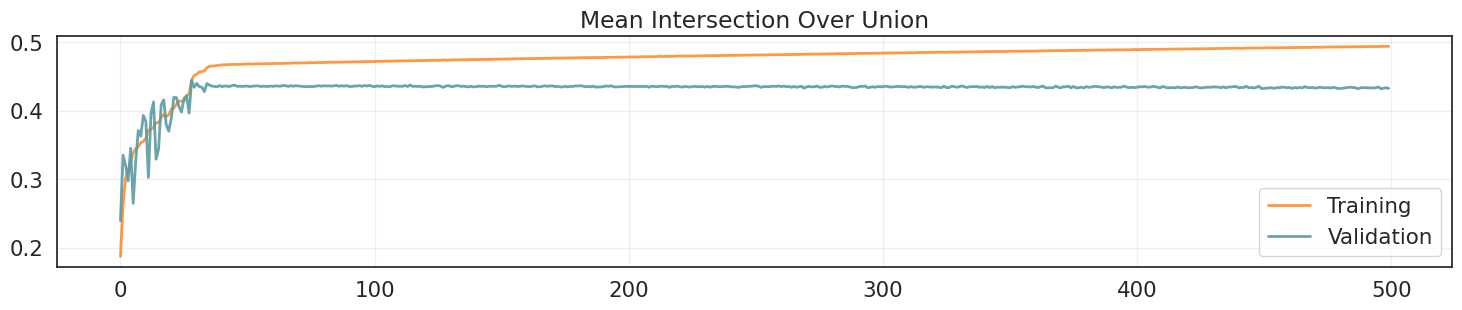

In [ ]:
loss = dice_loss
plot_history(train(loss_fn=loss, train_dataset=train_dataset, val_dataset=val_dataset), loss)

Test Accuracy: 0.5102
Test Mean Intersection over Union: 0.23


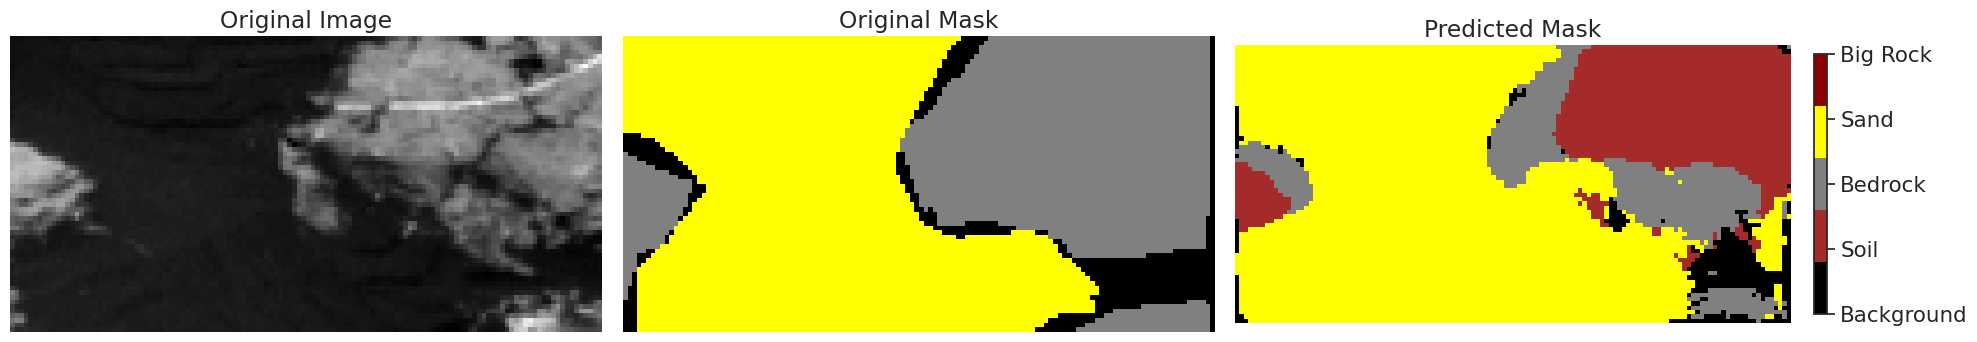

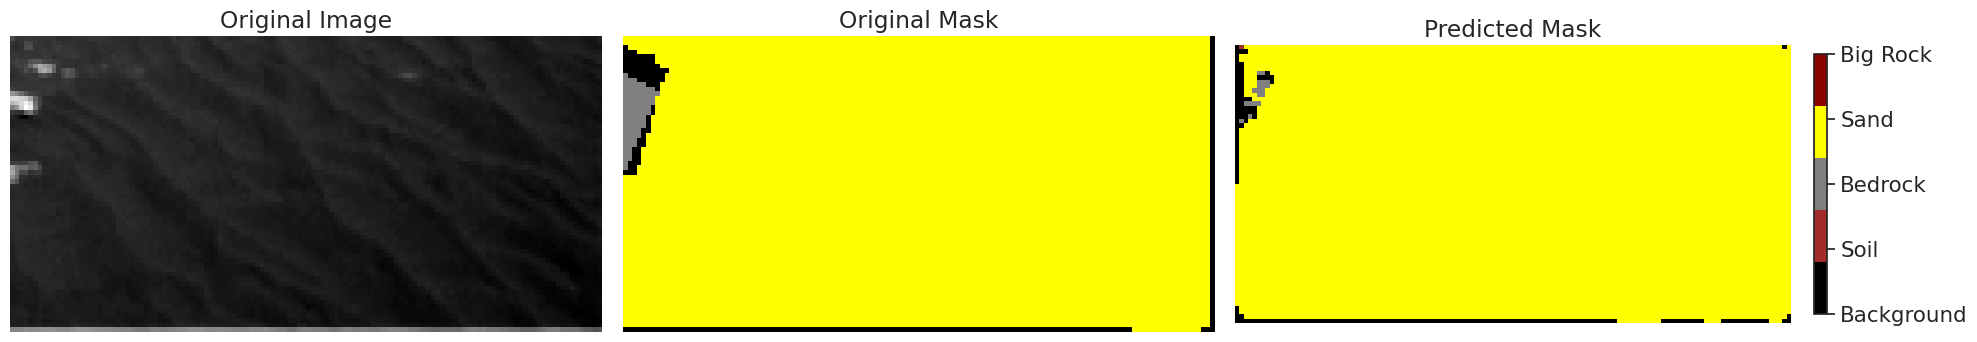

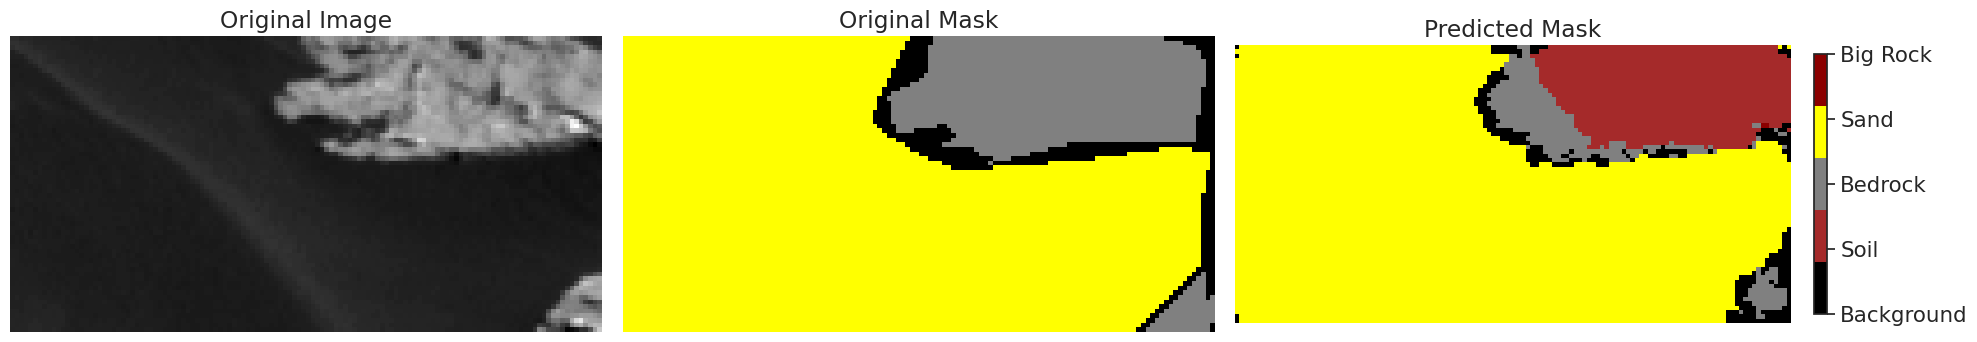

In [ ]:
# Load model
model = tfk.models.load_model(os.path.join('loss_functions', 'UNet_function_44.44_20241201-221944.keras'), compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=dice_loss,
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

# Plot three random samples
plot_triptychs(test_dataset, model, num_samples=3)

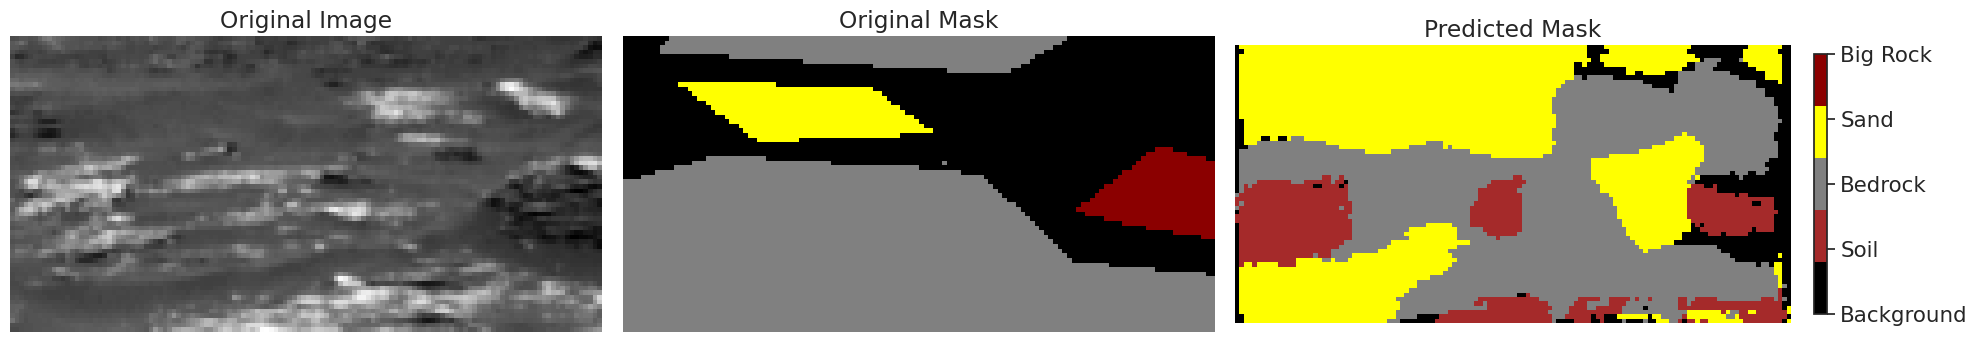

In [ ]:
# Plot triptychs using the filtered dataset
plot_triptychs(filtered_test_dataset, model, num_samples=5, seed=42)

## Dice + Weighted Cross-Entropy Loss

Epoch 1/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.3924 - loss: 0.3727 - mean_iou: 0.1511 - val_accuracy: 0.5188 - val_loss: 0.3057 - val_mean_iou: 0.2331 - learning_rate: 1.0000e-04
Epoch 2/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.5344 - loss: 0.2919 - mean_iou: 0.2673 - val_accuracy: 0.6189 - val_loss: 0.2418 - val_mean_iou: 0.3353 - learning_rate: 1.0000e-04
Epoch 3/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5695 - loss: 0.2702 - mean_iou: 0.2959 - val_accuracy: 0.6423 - val_loss: 0.2247 - val_mean_iou: 0.3332 - learning_rate: 1.0000e-04
Epoch 4/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5850 - loss: 0.2615 - mean_iou: 0.3091 - val_accuracy: 0.6289 - val_loss: 0.2302 - val_mean_iou: 0.3577 - learning_rate: 1.0000e-04
Epoch 5/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5947 - loss: 0.2534 - mean_iou: 0.3183 - val_accuracy: 0.5741 - val_loss: 0.2573 - val_mean_iou: 0.3246 - learning_rate: 1.0000e-0

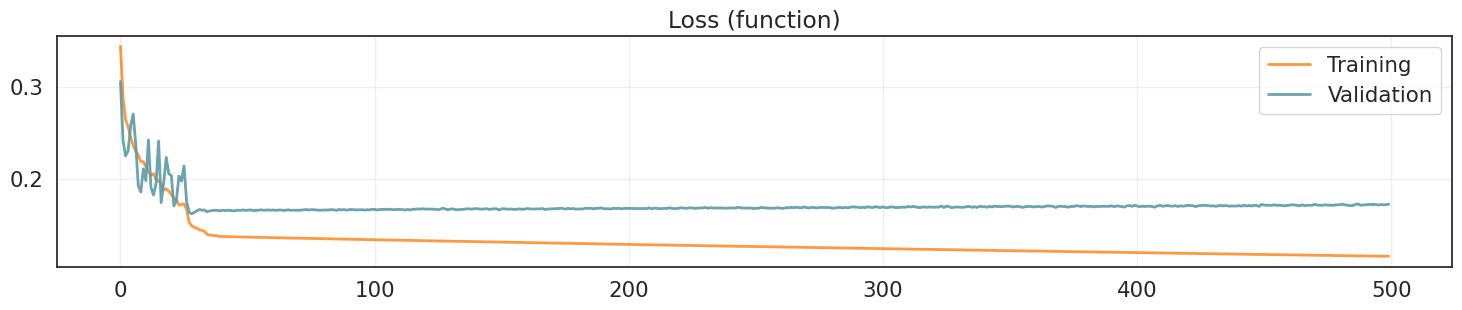

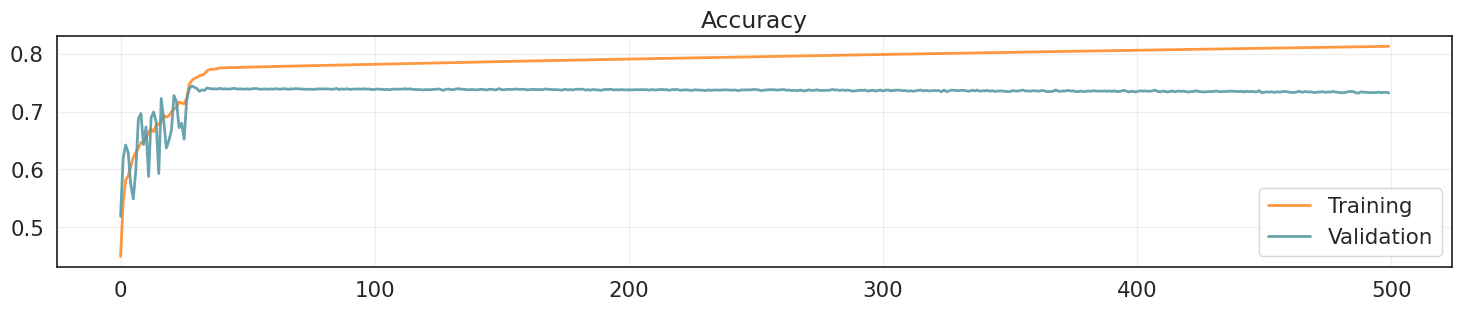

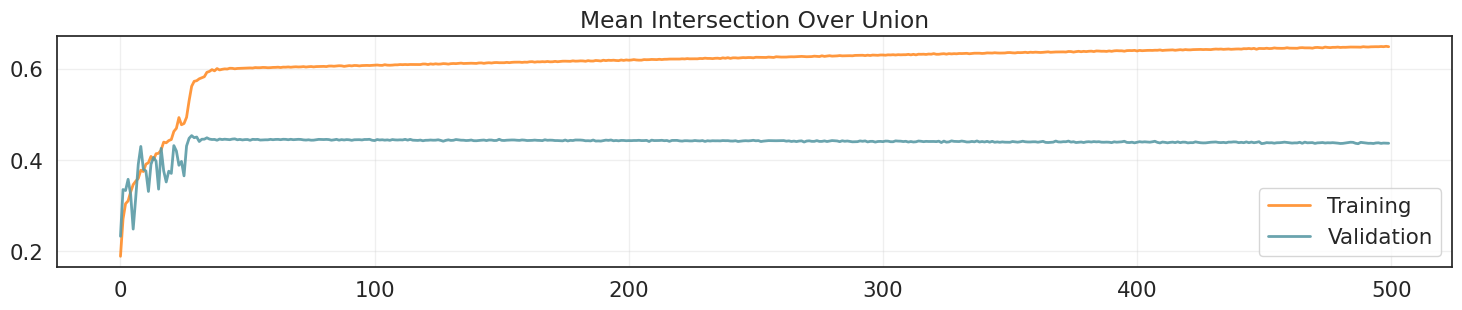

In [ ]:
loss = combined_loss(normalized_weights)
plot_history(train(loss_fn=loss, train_dataset=train_dataset, val_dataset=val_dataset), loss)

Test Accuracy: 0.5014
Test Mean Intersection over Union: 0.2223


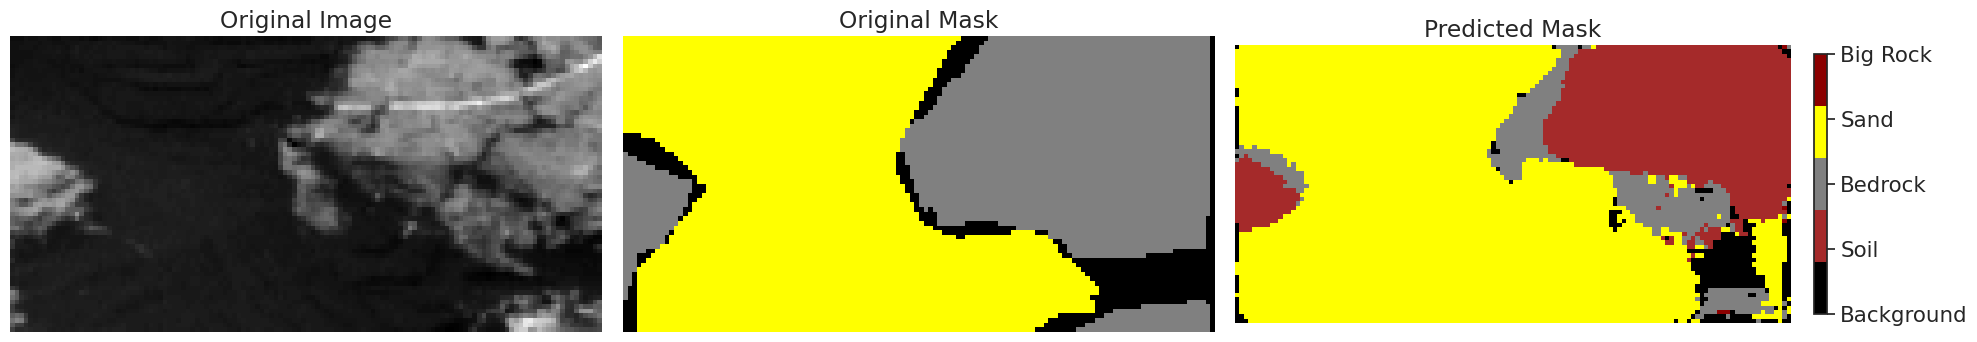

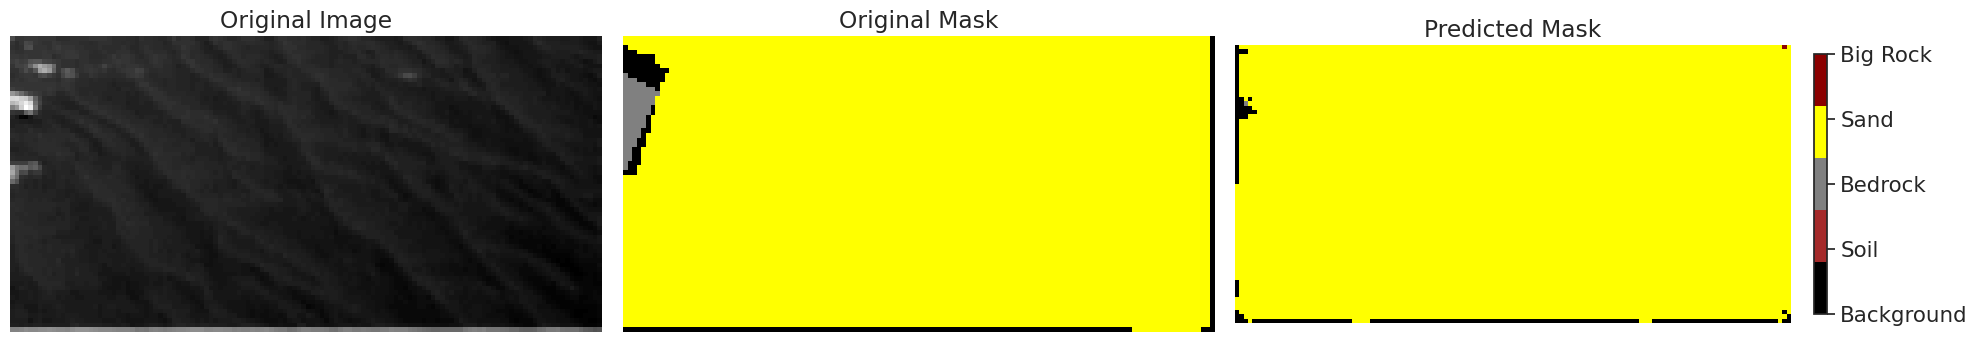

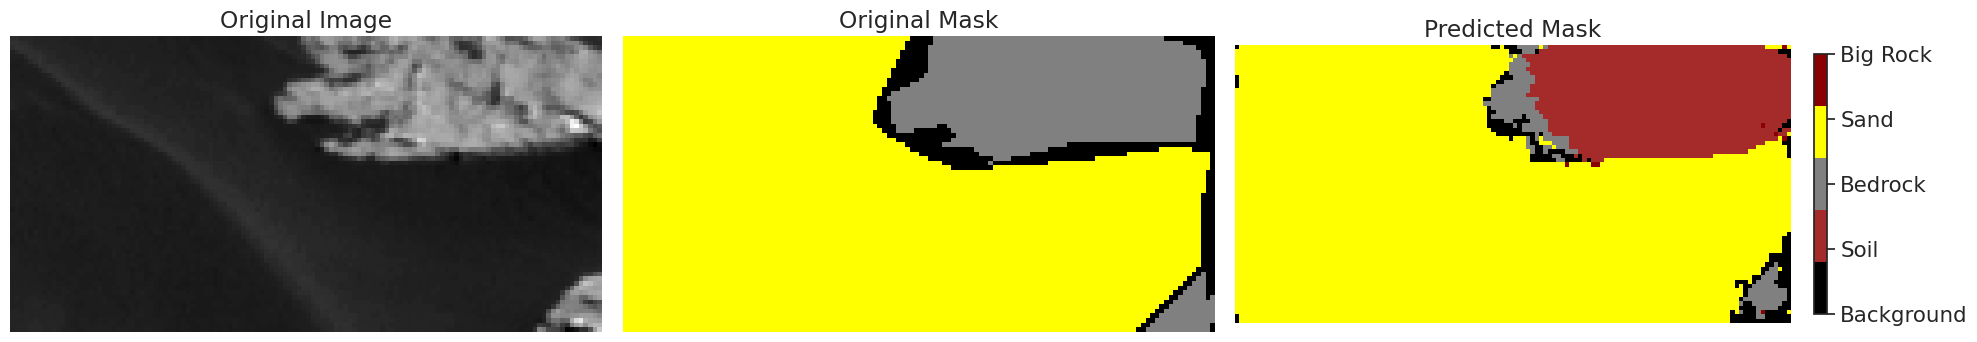

In [ ]:
# Load model
model = tfk.models.load_model(os.path.join('loss_functions', 'UNet_function_45.34_20241201-222201.keras'), compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=combined_loss(normalized_weights),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

# Plot three random samples
plot_triptychs(test_dataset, model, num_samples=3)

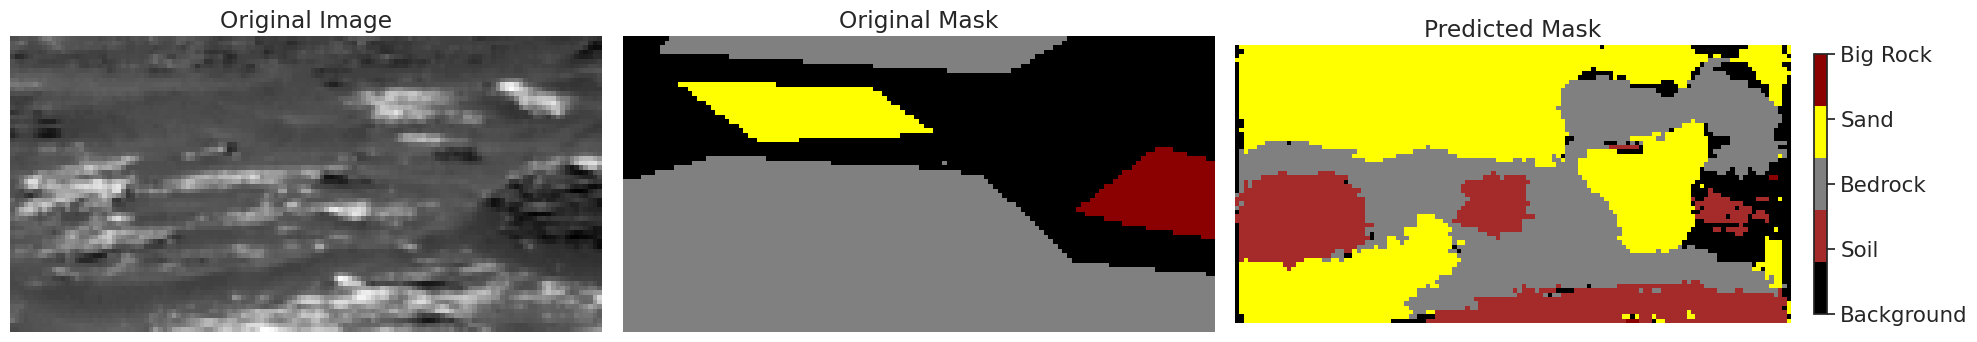

In [ ]:
# Plot triptychs using the filtered dataset
plot_triptychs(filtered_test_dataset, model, num_samples=5, seed=42)

## Comparison

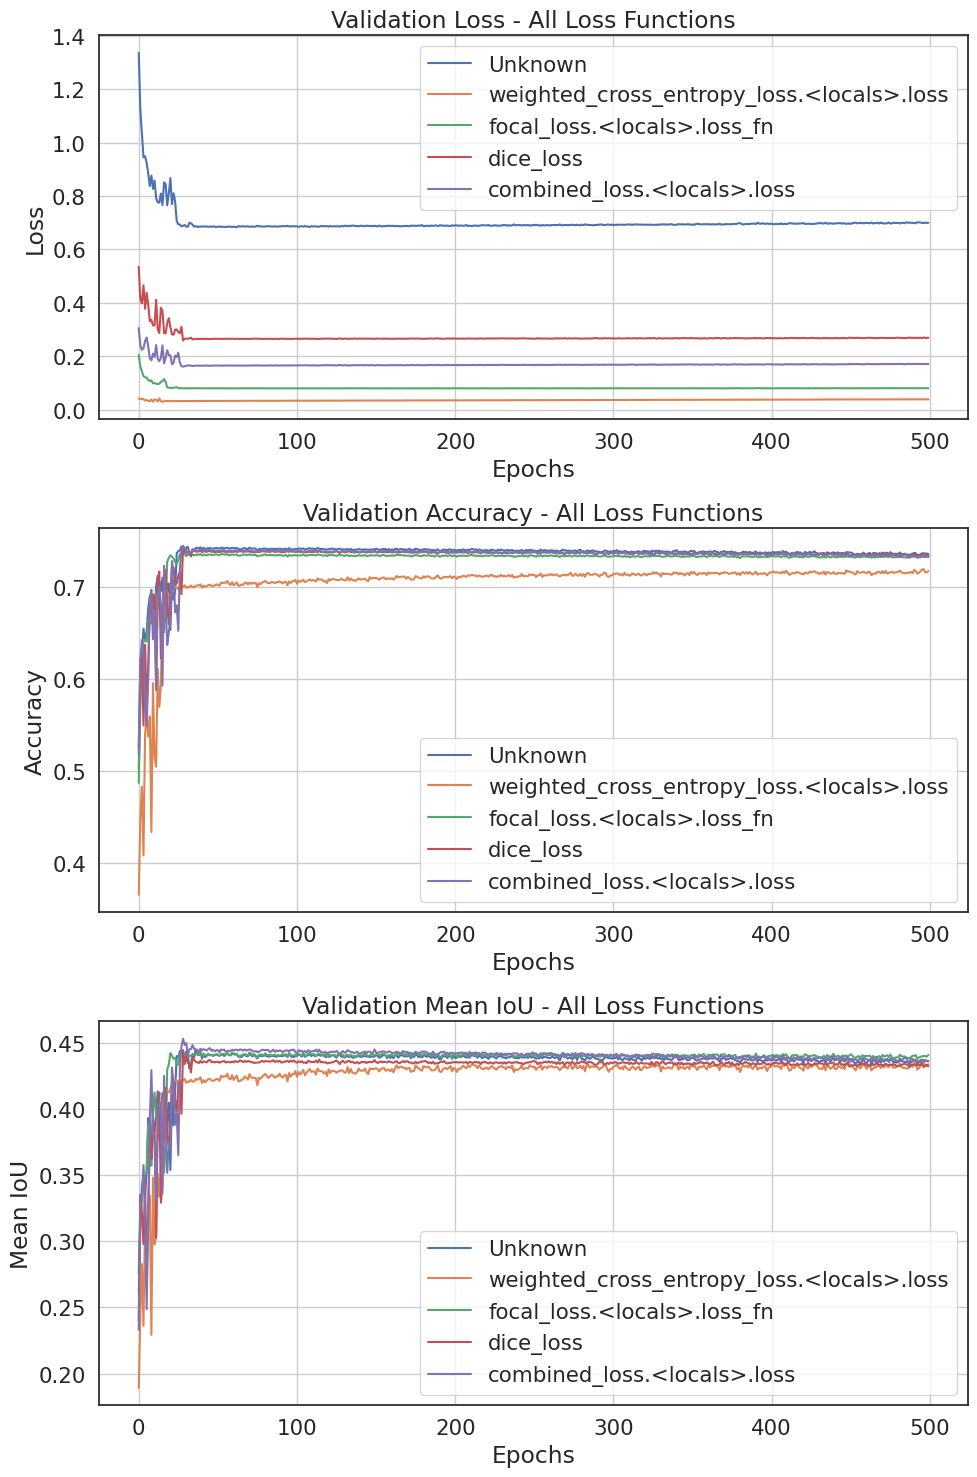

In [ ]:
import re

# Path to the directory containing history JSON files
history_directory = "loss_functions"

# Initialize dictionaries to store metrics for each loss function
loss_data = {}
accuracy_data = {}
mean_iou_data = {}
loss_fn_names = []  # Store the names of the loss functions

# Function to extract the loss function name from the filename
def extract_loss_fn_name(filename):
    match = re.search(r'function (\S+)', filename)
    if match:
        return match.group(1)
    else:
        return "Unknown"

# Load all history files from the directory
for filename in os.listdir(history_directory):
    if filename.endswith(".json"):
        # Get the full path of the JSON file
        file_path = os.path.join(history_directory, filename)

        # Load the JSON file
        with open(file_path, 'r') as f:
            history = json.load(f)

        # Extract the loss function name from the filename
        loss_fn_name = extract_loss_fn_name(filename)

        # Store loss function name
        loss_fn_names.append(loss_fn_name)

        # Extract relevant metrics
        val_losses = history.get('val_loss', [])
        val_accuracies = history.get('val_accuracy', [])
        val_mean_iou = history.get('val_mean_iou', [])

        # Store the metrics in dictionaries
        loss_data[loss_fn_name] = val_losses
        accuracy_data[loss_fn_name] = val_accuracies
        mean_iou_data[loss_fn_name] = val_mean_iou

# Assuming all histories have the same number of epochs (check if they do)
epochs = range(len(next(iter(loss_data.values()))))

# Plot settings
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Top subplot: Validation Loss
for loss_fn, losses in loss_data.items():
    axs[0].plot(epochs, losses, label=loss_fn)
axs[0].set_title('Validation Loss - All Loss Functions')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='best')
axs[0].grid(True)

# Middle subplot: Validation Accuracy
for loss_fn, accuracies in accuracy_data.items():
    axs[1].plot(epochs, accuracies, label=loss_fn)
axs[1].set_title('Validation Accuracy - All Loss Functions')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='best')
axs[1].grid(True)

# Bottom subplot: Validation Mean IoU
for loss_fn, mean_ious in mean_iou_data.items():
    axs[2].plot(epochs, mean_ious, label=loss_fn)
axs[2].set_title('Validation Mean IoU - All Loss Functions')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Mean IoU')
axs[2].legend(loc='best')
axs[2].grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Focal Loss Hyperparameters Search

In [ ]:
def train_unet(loss_fn, train_dataset, val_dataset, model_name='UNet'):
    global LEARNING_RATE, EPOCHS, NUM_CLASSES, callbacks

    # Create the model
    model = unet()

    # Compile the model
    model.compile(
        loss=loss_fn,
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
        metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
    )

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=1
    ).history

    # Calculate the final validation MeanIoU
    final_val_meanIoU = round(max(history.get('val_mean_iou', [0])) * 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

    # Create a timestamp for unique file naming
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # Save the model with the accuracy in the filename
    model_filename = f'{model_name}_{loss_fn.__class__.__name__}_{final_val_meanIoU}_{timestamp}.keras'
    model.save(model_filename)
    print(f'Model saved as {model_filename}')

    # Save training history as a JSON file
    history_filename = f"history_{model_name}_{loss_fn.__class__.__name__}_{timestamp}.json"
    with open(history_filename, 'w') as f:
        json.dump(history, f)
    print(f"Training history saved as {history_filename}")

    # Delete the model to free up resources
    del model

    # Return the history dictionary
    return history

In [ ]:
model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_conv1         │ (None, 64, 128, 32)    │            320 │ input_layer[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_bn1           │ (None, 64, 128, 32)    │            128 │ down_block1_conv1[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_activation1   │ (None, 64, 128, 32)    │              0 │ down_block1_bn1[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_conv2         │ (None, 64, 128, 32)    │          9,248 │ down_block1_activatio… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_bn2           │ (None, 64, 128, 32)    │            128 │ down_block1_conv2[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block1_activation2   │ (None, 64, 128, 32)    │              0 │ down_block1_bn2[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 64, 32)     │              0 │ down_block1_activatio… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_conv1         │ (None, 32, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_bn1           │ (None, 32, 64, 64)     │            256 │ down_block2_conv1[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_activation1   │ (None, 32, 64, 64)     │              0 │ down_block2_bn1[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_conv2         │ (None, 32, 64, 64)     │         36,928 │ down_block2_activatio… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_bn2           │ (None, 32, 64, 64)     │            256 │ down_block2_conv2[0][… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ down_block2_activatio

 Total params: 473,669 (1.81 MB)

 Trainable params: 472,389 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

Grid search: loop over each combination of alpha and gamma, train the model

In [ ]:
# Define the grid of alpha and gamma values
alpha_values = [0.25, 0.5]
gamma_values = [1.0, 2.0]

# Create combinations (Total of 5 combinations)
grid = [
    (alpha_values[0], gamma_values[0]),
    (alpha_values[0], gamma_values[1]),
    (alpha_values[1], gamma_values[0]),
    (alpha_values[1], gamma_values[1]),
]

# Initialize a list to store results
results = []

for alpha, gamma in grid:
    print(f"\nTraining with alpha={alpha}, gamma={gamma}")
    # Define the loss function with current alpha and gamma
    loss = focal_loss(alpha=alpha, gamma=gamma)
    # Train the model
    history = train_unet(
        loss_fn=loss, train_dataset=train_dataset,
        val_dataset=val_dataset,
        model_name=f'UNet_alpha{alpha}_gamma{gamma}'
    )
    # Get the final validation MeanIoU from history
    final_val_meanIoU = round(max(history.get('val_mean_iou', [0])) * 100, 2)
    # Store the results
    results.append({'alpha': alpha, 'gamma': gamma, 'val_mean_iou': final_val_meanIoU})


Training with alpha=0.25, gamma=1.0
Epoch 1/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.3304 - loss: 0.3330 - mean_iou: 0.1001 - val_accuracy: 0.4824 - val_loss: 0.2602 - val_mean_iou: 0.2228 - learning_rate: 1.0000e-04
Epoch 2/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5216 - loss: 0.2239 - mean_iou: 0.2610 - val_accuracy: 0.5273 - val_loss: 0.2174 - val_mean_iou: 0.2563 - learning_rate: 1.0000e-04
Epoch 3/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5576 - loss: 0.2037 - mean_iou: 0.2968 - val_accuracy: 0.6529 - val_loss: 0.1618 - val_mean_iou: 0.3600 - learning_rate: 1.0000e-04
Epoch 4/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5744 - loss: 0.1915 - mean_iou: 0.3057 - val_accuracy: 0.6454 - val_loss: 0.1670 - val_mean_iou: 0.3570 - learning_rate: 1.0000e-04
Epoch 5/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6013 - loss: 0.1799 - mean_iou: 0.3335 - val_accuracy: 0.6731 - val_loss: 0.1486 - val_mean_io

We create a pandas dataframe to display the results and identify the best hyperparameters

In [ ]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Sort the DataFrame by validation MeanIoU
results_df = results_df.sort_values(by='val_mean_iou', ascending=False)

# Display the results
print("\nGrid Search Results:")
print(results_df)


Grid Search Results:
   alpha  gamma  val_mean_iou
1   0.25    2.0         44.65
2   0.50    1.0         43.92
3   0.50    2.0         43.60
0   0.25    1.0         43.27


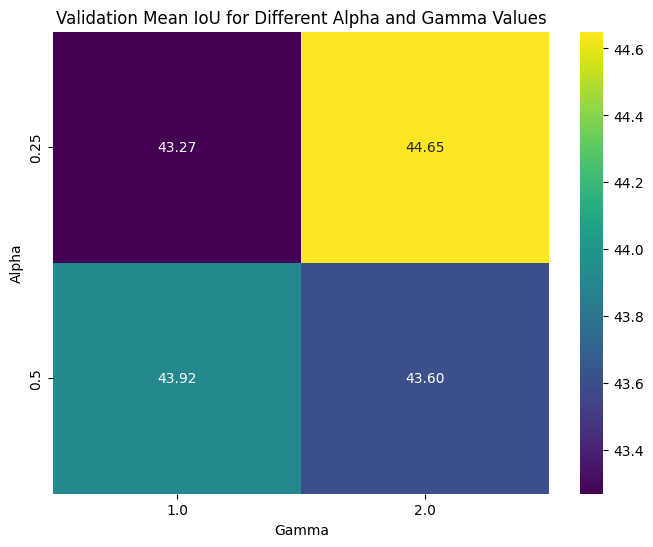


Best Alpha: 0.25, Best Gamma: 2.0


In [ ]:
# Visualize the results
pivot_table = results_df.pivot(index='alpha', columns='gamma', values='val_mean_iou')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='viridis')
plt.title('Validation Mean IoU for Different Alpha and Gamma Values')
plt.ylabel('Alpha')
plt.xlabel('Gamma')
plt.show()


# Identify the best parameters
best_result = results_df.iloc[0]
best_alpha = best_result['alpha']
best_gamma = best_result['gamma']
print(f"\nBest Alpha: {best_alpha}, Best Gamma: {best_gamma}")

## Best Focal Loss

In [ ]:
def plot_history(history, loss_fn_name):
    """
    Plots training and validation loss, accuracy, and mean IoU from the training history.

    Parameters:
    history (dict): The training history containing 'loss', 'val_loss', 'accuracy', 'val_accuracy',
                    'mean_iou', and 'val_mean_iou'.
    loss_fn_name (str): The name of the loss function used in the training (e.g., 'Focal Loss').
    """
    metrics = {
        "Loss (" + loss_fn_name + ")": ("loss", "val_loss"),
        "Accuracy": ("accuracy", "val_accuracy"),
        "Mean Intersection Over Union": ("mean_iou", "val_mean_iou")
    }

    # Plot the metrics
    for title, (train_key, val_key) in metrics.items():
        plt.figure(figsize=(10, 4))
        plt.plot(history[train_key], label='Training', alpha=0.8, linewidth=2)
        plt.plot(history[val_key], label='Validation', alpha=0.9, linewidth=2)
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel(title.split(" ")[0])
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

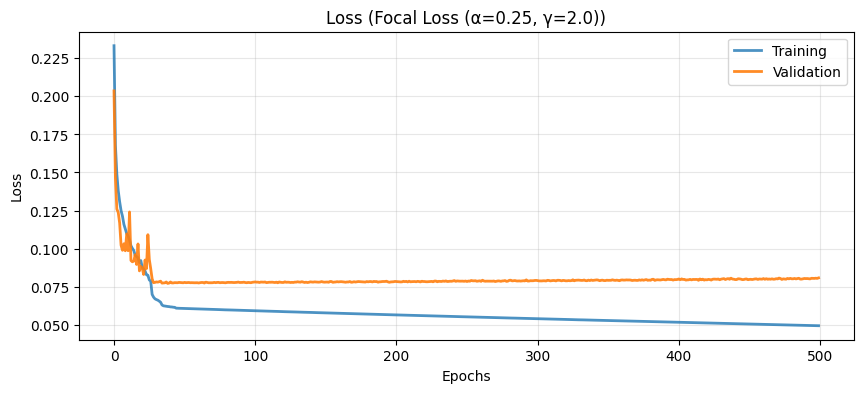

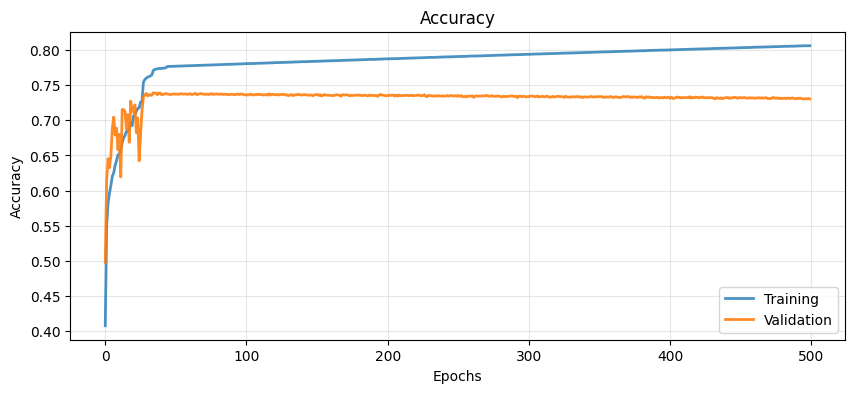

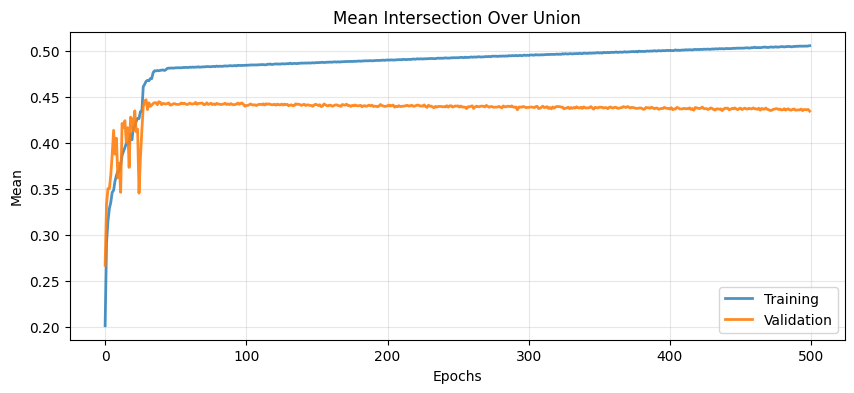

In [ ]:
# Proceed to load and process the history as needed
if history_filename:
    with open(history_filename, 'r') as f:
        history = json.load(f)
else:
    history = None

# Plot the history if it's loaded
if history:
    plot_history(history, loss_fn_name=f'Focal Loss (α={best_alpha}, γ={best_gamma})')


Best Alpha: 0.25, Best Gamma: 2.0
Loading model UNet_alpha0.25_gamma2.0_function_44.65_20241203-215034.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - accuracy: 0.7101 - loss: 0.0904 - mean_iou: 0.4350

Test Loss: 0.0883
Test Accuracy: 0.7235
Test Mean Intersection over Union: 0.4302
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
Image shape after squeezing: (64, 128)
True mask shape: (64, 128)
Predicted mask shape: (64, 128)


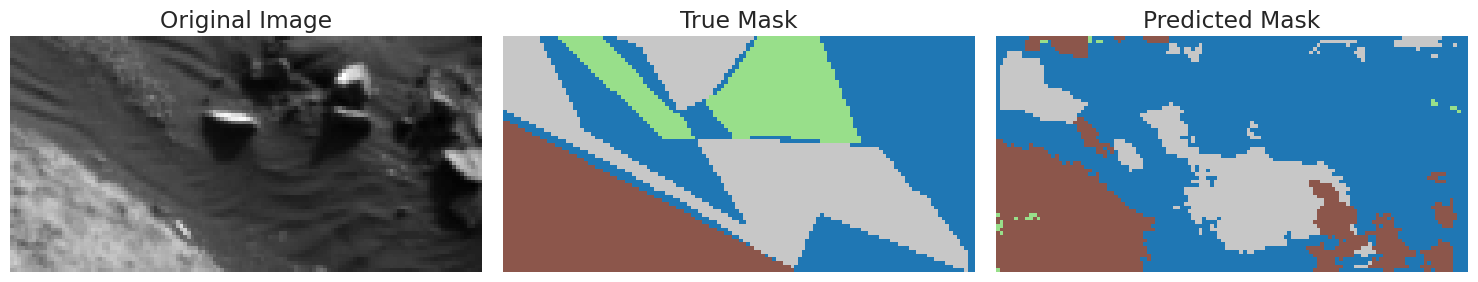

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Image shape after squeezing: (64, 128)
True mask shape: (64, 128)
Predicted mask shape: (64, 128)


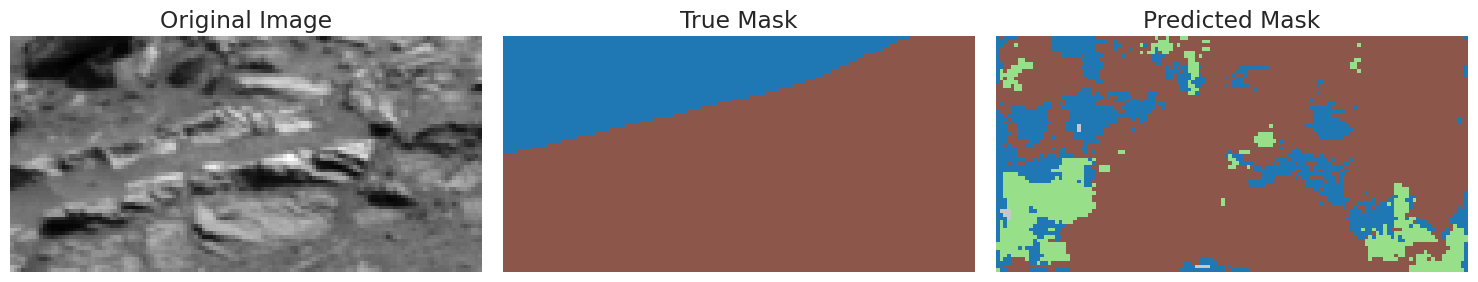

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Image shape after squeezing: (64, 128)
True mask shape: (64, 128)
Predicted mask shape: (64, 128)


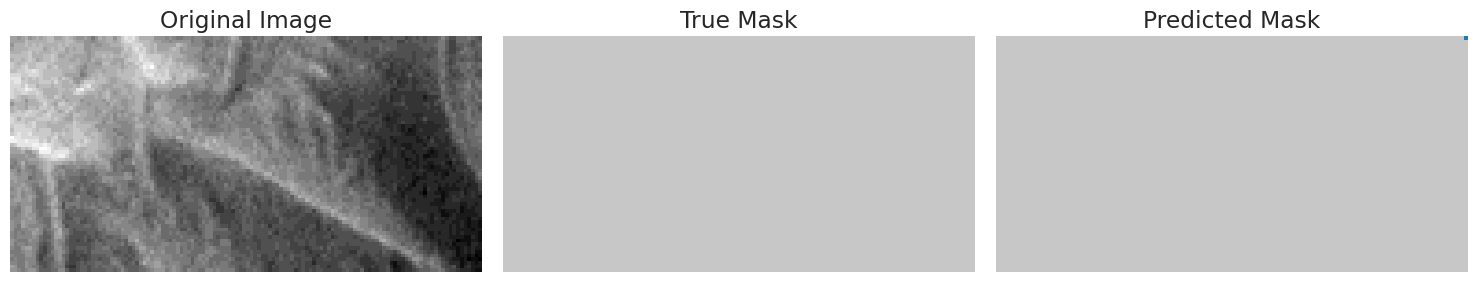

In [ ]:
import glob

# Get the best parameters
best_result = results_df.iloc[0]
best_alpha = best_result['alpha']
best_gamma = best_result['gamma']
best_val_mean_iou = best_result['val_mean_iou']
print(f"\nBest Alpha: {best_alpha}, Best Gamma: {best_gamma}")

# Load the best model
model_name_pattern = f'UNet_alpha{best_alpha}_gamma{best_gamma}*.keras'
model_files = glob.glob(model_name_pattern)
if model_files:
    best_model_file = model_files[0]  # Assuming only one file matches
    print(f"Loading model {best_model_file}")
else:
    print("Best model file not found.")
    best_model_file = None

if best_model_file:
    # Define custom_objects dictionary
    custom_objects = {
        'focal_loss': focal_loss(alpha=best_alpha, gamma=best_gamma),
        'MeanIntersectionOverUnion': MeanIntersectionOverUnion
    }

    # Load the model with custom objects
    model = tfk.models.load_model(best_model_file, custom_objects=custom_objects, compile=False)

    # Compile the model
    model.compile(
        loss=focal_loss(alpha=best_alpha, gamma=best_gamma),
        optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
        metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
    )

    # Evaluate on the test set
    test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=1, batch_size=10)
    print(f'\nTest Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'Test Mean Intersection over Union: {test_mean_iou:.4f}')

    # Plot sample predictions
    plot_triptychs(test_dataset, model, num_samples=3)
else:
    print("Cannot proceed without the best model file.")